# Задача проекта

- Заказчик: Благотворительный фонд “Бюро добрых дел”
- Основная цель заказчика заключается в том, чтобы из пула тех клиентов, которые жертвовали за последний год, выявить клиентов, которые могут увеличить частоту или размер пожертвований.
- Данные, которыми располагает заказчик, включают в себя историю платежей жертвователей и какую-то дополнительную информацию за несколько лет по четырём тысячам жертвователей.
- Жизненный цикл жертвователя составляет от полутора до трёх лет, поэтому в истории будут примеры того, как именно меняется характер платежей клиентов.
- Если получится на основе данных сделать дополнительную сегментацию, например выделить характерное поведение пользователей, которые прекращают жертвовать, это также интересует заказчика.
- Данные реальные, задача интересная, успешное её решение приведёт к тому, что больше людей получат ту помощь, в которой нуждаются.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
import phik
import lightgbm as lgb
import shap

In [2]:

from pyod.models.knn import KNN
from sklearn.ensemble import IsolationForest
from catboost import CatBoostClassifier
from catboost import cv, Pool
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from phik import resources, report
from tqdm import tqdm
from sklearn import preprocessing
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import roc_auc_score, roc_curve ,log_loss, confusion_matrix,accuracy_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

In [3]:

donors = pd.read_excel('/Users/armineagajanyan/Downloads/Выгрузка для ЯП_2.xlsx', sheet_name='Доноры')
donats = pd.read_excel('/Users/armineagajanyan/Downloads/Выгрузка для ЯП_2.xlsx', sheet_name='Пожертвования')


In [4]:
#создадим функцию для информации
def table_info(df):
    display(df.info())
    display(df.head())
    display(df.describe())
    display(df.isna().mean())
    return df

# Датасет donors

In [5]:
table_info(donors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ID                               3683 non-null   object        
 1   Пол                              2431 non-null   object        
 2   Город                            1015 non-null   object        
 3   Дата последней email активности  1835 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 115.2+ KB


None

,ID,Пол,Город,Дата последней email активности
0,AF575B85-917F-475D-8875-00055586E05B,NaN,NaN,NaT
1,229A9B43-3A15-4A48-8CB6-000EDB240D50,NaN,NaN,NaT
2,C6606486-05A8-4437-ACF9-00344E54FEE1,NaN,NaN,NaT
3,6ED86154-A688-4A11-868F-006209035413,Женский ...,NaN,NaT
4,46C41E20-EA56-4698-9C37-00692FD6FFE8,Женский ...,NaN,NaT


Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,ID,Пол,Город,Дата последней email активности
count,3683,2431,1015,1835
unique,3683,2,234,653
top,AF575B85-917F-475D-8875-00055586E05B,Женский ...,Москва,2022-07-18 16:29:49
freq,1,1874,458,294
first,NaN,NaN,NaN,2020-01-30 11:41:46
last,NaN,NaN,NaN,2022-07-28 20:34:28


ID                                 0.000000
Пол                                0.339940
Город                              0.724409
Дата последней email активности    0.501765
dtype: float64

,ID,Пол,Город,Дата последней email активности
0,AF575B85-917F-475D-8875-00055586E05B,NaN,NaN,NaT
1,229A9B43-3A15-4A48-8CB6-000EDB240D50,NaN,NaN,NaT
2,C6606486-05A8-4437-ACF9-00344E54FEE1,NaN,NaN,NaT
3,6ED86154-A688-4A11-868F-006209035413,Женский ...,NaN,NaT
4,46C41E20-EA56-4698-9C37-00692FD6FFE8,Женский ...,NaN,NaT
...,...,...,...,...
3678,C5E55606-9BFC-48C0-BE7F-FFC10A10DF20,Женский ...,NaN,NaT
3679,3CB754A9-7B08-40FB-A350-FFDB291DA9E1,NaN,NaN,NaT
3680,3F073C3B-E567-428E-B16F-FFE09A8D2CE0,Женский ...,NaN,2022-07-18 16:29:34
3681,029C3CEE-2381-4050-8E91-FFE3030218D4,Женский ...,КУШВА,NaT


In [6]:
donors['Пол'].value_counts(dropna=False).to_frame()

,Пол
Женский,1874
NaN,1252
Мужской,557


In [7]:
#топ 10 городов
donors['Город'].value_counts(dropna=False).to_frame().head(10)

,Город
NaN,2668
Москва,458
Санкт-Петербург,78
Краснодар,23
Нижний Новгород,20
Новосибирск,19
Якутск,14
Саратов,13
Ростов-на-Дону,12
Казань,11


In [8]:
donors['Дата последней email активности'].value_counts(dropna=False).to_frame()

,Дата последней email активности
NaT,1848
2022-07-18 16:29:49,294
2022-07-18 16:29:48,229
2022-07-18 16:29:50,163
2022-07-18 16:29:47,114
...,...
2022-06-24 19:09:13,1
2022-07-19 10:00:01,1
2022-07-18 17:22:28,1
2022-07-22 09:42:47,1


In [9]:
donors['Дата последней email активности'].value_counts(dropna=False)

NaT                    1848
2022-07-18 16:29:49     294
2022-07-18 16:29:48     229
2022-07-18 16:29:50     163
2022-07-18 16:29:47     114
                       ... 
2022-06-24 19:09:13       1
2022-07-19 10:00:01       1
2022-07-18 17:22:28       1
2022-07-22 09:42:47       1
2020-10-08 17:42:07       1
Name: Дата последней email активности, Length: 654, dtype: int64

# Датасет donats

In [10]:
table_info(donats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14043 entries, 0 to 14042
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Donor ID            14043 non-null  object        
 1   Дата платежа        14043 non-null  datetime64[ns]
 2   Сумма платежа       14043 non-null  float64       
 3   Рекуррентный        14043 non-null  object        
 4   Назначение платежа  12774 non-null  object        
 5   Канал оплаты        14043 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 658.4+ KB


None

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
3,F1310736-B229-4AAC-99B7-F13ACECF67CB,2019-12-26 02:25:42,300.0,Нет ...,NaN,SMS
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты


,Сумма платежа
count,1.404300e+04
mean,1.720846e+03
std,2.949977e+04
min,1.000000e-02
25%,1.500000e+02
50%,3.500000e+02
75%,7.000000e+02
max,3.000000e+06


Donor ID              0.000000
Дата платежа          0.000000
Сумма платежа         0.000000
Рекуррентный          0.000000
Назначение платежа    0.090365
Канал оплаты          0.000000
dtype: float64

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
3,F1310736-B229-4AAC-99B7-F13ACECF67CB,2019-12-26 02:25:42,300.0,Нет ...,NaN,SMS
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
...,...,...,...,...,...,...
14038,0B6DA68C-558B-4153-806E-B1D775585B88,2015-12-12 14:50:34,100.0,Да ...,Пожертвование в фонд помощи детям-отказникам и...,Банковские карты
14039,793690C0-6332-4289-96B4-2CF8902ACEF5,2020-12-02 09:59:13,200.0,Да ...,ПОЖЕРТВОВАНИЕ,Банковские карты
14040,69613503-5B71-4690-ACB5-8E783FF915B4,2021-12-26 00:00:00,500.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
14041,144B2E46-2A6A-48DE-92FB-729C3897A2B4,2018-11-27 16:35:01,200.0,Да ...,Пожертвование в фонд помощи детям-отказникам и...,Банковские карты


In [11]:
donats['Дата платежа'].min(), donats['Дата платежа'].max()

(Timestamp('2015-07-19 20:10:11'), Timestamp('2022-07-28 19:22:15'))

<AxesSubplot:>

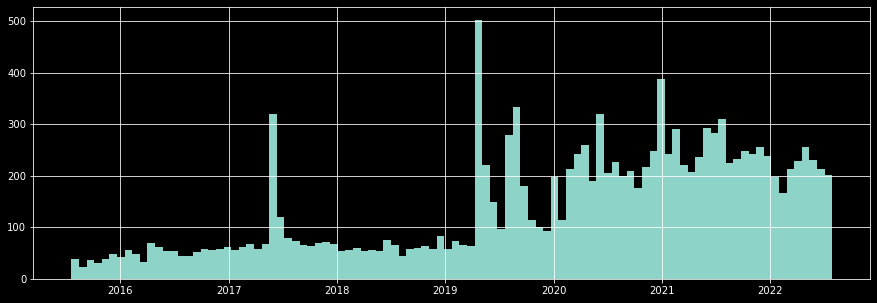

In [12]:
donats['Дата платежа'].hist(figsize = (15, 5), bins=100)

array([[<AxesSubplot:title={'center':'Дата платежа'}>,
        <AxesSubplot:title={'center':'Сумма платежа'}>]], dtype=object)

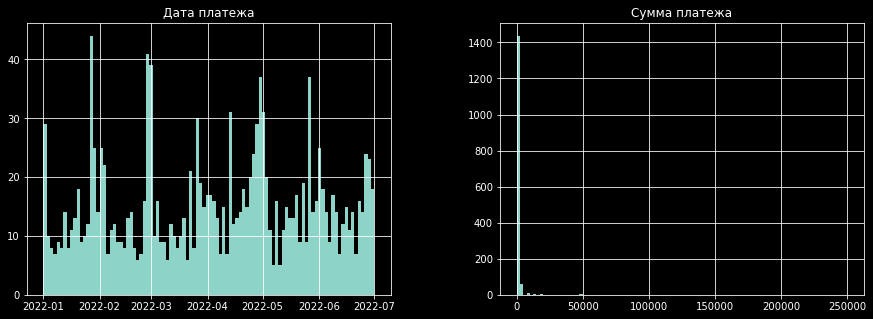

In [13]:
donats[donats['Дата платежа'].between('2022-01-01', '2022-07-01')].hist(figsize = (15, 5), bins=100)

array([[<AxesSubplot:title={'center':'Дата платежа'}>,
        <AxesSubplot:title={'center':'Сумма платежа'}>]], dtype=object)

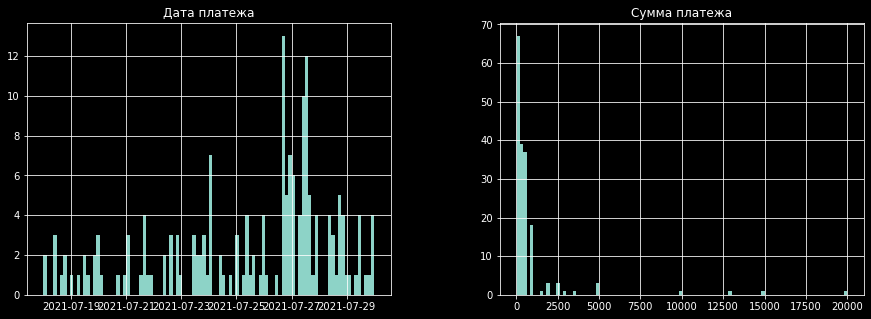

In [14]:
donats[donats['Дата платежа'].between('2021-07-18', '2021-07-30')].hist(figsize = (15, 5), bins=100)

In [15]:
donats['Сумма платежа'].describe().round()

count      14043.0
mean        1721.0
std        29500.0
min            0.0
25%          150.0
50%          350.0
75%          700.0
max      3000000.0
Name: Сумма платежа, dtype: float64

<AxesSubplot:>

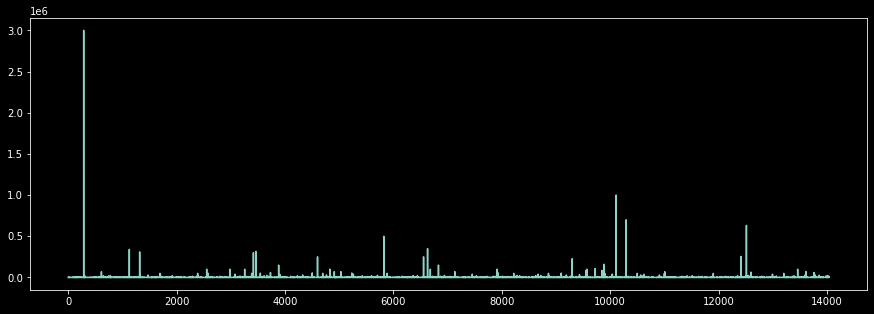

In [16]:
donats['Сумма платежа'].plot(figsize = (15, 5))

<AxesSubplot:>

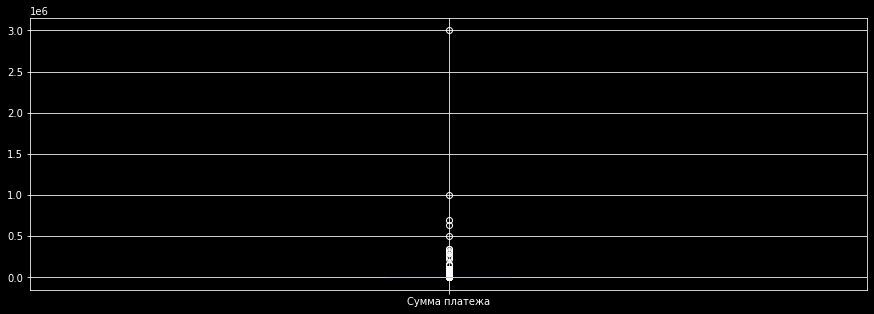

In [17]:
donats.boxplot(column=['Сумма платежа'], figsize = (15, 5))

In [18]:
donats['Рекуррентный'].value_counts(dropna=True).to_frame()

,Рекуррентный
Да,8085
Нет,5958


In [19]:
donats['Назначение платежа'].value_counts(dropna=True).to_frame().head(70)
                                                                    

,Назначение платежа
ПОЖЕРТВОВАНИЕ,3811
"Пожертвование в фонд помощи детям-отказникам и детям-сиротам ""Бюро Добрых Дел""",3335
ПОЖЕРТВОВАНИЕ undefined,2162
Добровольное пожертвование. НДС не облагается,497
SMS bdd,253
...,...
На обучение Дарьи,12
Фотомастерская для Февронии,11
На программу Окно в мир,11
День рождения со смыслом,11


# №2. Предобработка данных

In [20]:
# сравним количество уникальных id в обеих датасетах
display(len(donors['ID'].unique()))
len(donats['Donor ID'].unique())

3683

3683

In [21]:
#проверим на дубликаты
'Количество дубликатов:', donors.duplicated().sum()


('Количество дубликатов:', 0)

In [22]:
#проверим на дубликаты
'Количество дубликатов:', donats.duplicated().sum()

('Количество дубликатов:', 12)

In [23]:
donats[donats.duplicated() == True]

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
133,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
297,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
1438,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
2837,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
5166,FFCCBA23-89CA-4A22-BD8A-7CAD2D9EB7F7,2021-09-13,20.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
7654,FFCCBA23-89CA-4A22-BD8A-7CAD2D9EB7F7,2021-09-13,20.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
9594,D38F6A22-9BEF-4484-B377-ED8ED1DB4553,2021-02-11,1.0,Нет ...,ДОБРОВОЛЬНОЕ ПОЖЕРТВОВАНИЕ;Сумма 1.00 руб.;Ком...,Прямые поступления на счет
10112,FFCCBA23-89CA-4A22-BD8A-7CAD2D9EB7F7,2021-09-13,20.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
10685,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
11757,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет


In [24]:
#eдаляем дубликаты и проверяем
donats = donats.drop_duplicates()
donats.duplicated().sum()

0

In [25]:
display(len(donors['ID'].unique()))
len(donats['Donor ID'].unique())

3683

3683

In [26]:
# т.к. количество уникальных id равны, объединим таблицы в одну,
# предварительно переименовав столбец в donats

donats = donats.rename(columns={'Donor ID' : 'ID'})

df = donats.merge(donors, how='left', on = 'ID')
df.head(2)

,ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты,Пол,Город,Дата последней email активности
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты,Женский ...,Москва,2022-06-03 20:15:57
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS,Женский ...,Москва,2022-07-18 17:19:02


In [27]:
len(donats['ID'].unique())

3683

In [28]:
# переименуем столбцы, приведя их к змеиному регистру
df = df.rename(columns = 
              {
                  'ID':'id',
                  'Дата платежа':'date',
                  'Сумма платежа':'amount',
                  'Пол':'gender',
                  'Город':'city',
                  'Назначение платежа' : 'purpose',
                  'Рекуррентный' : 'is_reccurent',
                  'Канал оплаты' : 'channel',
                  'Дата последней email активности': 'last_email_activity'
                  
              }
              )
df.columns

Index(['id', 'date', 'amount', 'is_reccurent', 'purpose', 'channel', 'gender',
       'city', 'last_email_activity'],
      dtype='object')

In [29]:
# посмотрим процентное соотношение пропусков
df.isna().mean()

id                     0.000000
date                   0.000000
amount                 0.000000
is_reccurent           0.000000
purpose                0.090443
channel                0.000000
gender                 0.111824
city                   0.519849
last_email_activity    0.210819
dtype: float64

In [30]:
#посмотрим тип данных
df.dtypes

id                             object
date                   datetime64[ns]
amount                        float64
is_reccurent                   object
purpose                        object
channel                        object
gender                         object
city                           object
last_email_activity    datetime64[ns]
dtype: object

In [31]:
#заполним пропуски в категориальных признаков no_info 
for column in ['gender', 'purpose']:            
    df[column].fillna('no_info', inplace=True)

In [32]:
# посмотрим процентное соотношение пропусков
df.isna().mean()

id                     0.000000
date                   0.000000
amount                 0.000000
is_reccurent           0.000000
purpose                0.000000
channel                0.000000
gender                 0.000000
city                   0.519849
last_email_activity    0.210819
dtype: float64

#построим графики
sns.pairplot(df)
#корреляция Пирсона
df.corr().style.background_gradient()

phik_overview = df.phik_matrix()

In [33]:
# Напишем функцию для категоризации городов

def city_category(city):
    foreign_cities = ['Frankfurt am Main', 'Charleston', 'Helsinki', 'Juba', 'Copenhagen', 'Holon', 
                     'Hyderabad', 'Alameda', 'Jakarta', 'Keighley', 'Southall', 'Denver']
    
    if city.loc['city'] == 'Москва':
        return 'Москва'
    elif city.loc['city'] == 'Санкт-Петербург':
        return 'Санкт-Петербург'
    elif city.loc['city'] in foreign_cities:
        return 'Зарубежные страны'
    elif city.loc['city'] == 0:
        return 'Город неизвестен'
    else:
        return 'Другие города России'

df['city'] = df['city'].fillna(0)
# применим функцию
df['city'] = df.apply(city_category, axis=1)
# удалим столбец 'city'
#df = df.drop('city',axis=1)

df.head(2)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты,Женский ...,Москва,2022-06-03 20:15:57
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS,Женский ...,Москва,2022-07-18 17:19:02


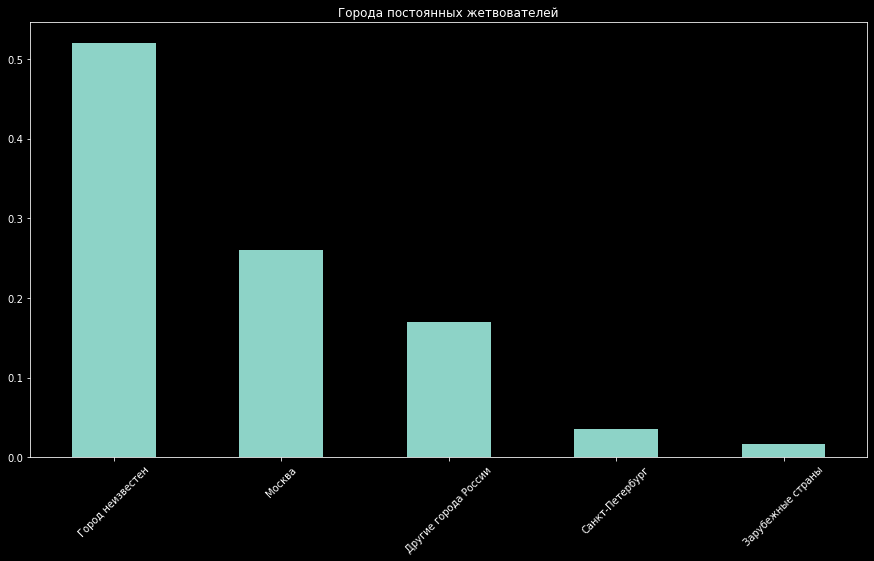

In [34]:
(df['city'].value_counts()/len(df['id'])).plot(
    title='Города постоянных жетвователей',
    kind='bar', 
    figsize=(15,8),
    rot=45
);

In [35]:
#приведем датасет к нижнему регистру
df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

In [36]:
#df['day_year'] = pd.DatetimeIndex(df['date']).year
#df['last_email_activity_year'] = pd.DatetimeIndex(df['last_email_activity']).year
#df['day_month'] = pd.DatetimeIndex(df['date']).month
#df['last_email_activity_month'] = pd.DatetimeIndex(df['last_email_activity']).month

#добавляем столбец lifetime: дейсвие договора в месяцах
#df['lifetime'] = (df['last_email_activity_year'] - df['day_year']) * 365 + (df['last_email_activity_month']
#                - df['day_month']) * 30

#df.loc[df['lifetime'] == 0, 'lifetime'] = 1

In [37]:

# в столбце 'is_reccurent' содержатся значения со множеством пробелов
# заменим их на более удобные 
df['is_reccurent'] = df['is_reccurent'].replace('да                                                                                                                                                                                                                                                        ',
                                                 1)
df['is_reccurent'] = df['is_reccurent'].replace('нет                                                                                                                                                                                                                                                       ',
                                                  0)

In [38]:
# доля назначений пожертвований
(df['purpose'].value_counts()/len(df['id'])).head(30)

пожертвование                                                                     0.272397
пожертвование в фонд помощи детям-отказникам и детям-сиротам "бюро добрых дел"    0.237688
пожертвование  undefined                                                          0.154087
no_info                                                                           0.090443
добровольное пожертвование. ндс не облагается                                     0.035136
sms bdd                                                                           0.018032
пожертвование клуб друзей                                                         0.009051
на психологические консультации артёму                                            0.006201
пожертвование без назначения                                                      0.005131
пожертвование на обучение артёма                                                  0.004419
пожертвование на обучение александры                                              0.004205

In [39]:
df['purpose'].fillna('no_info', inplace=True)


df['purpose'] = (df['purpose']
                 .str
                 .replace('пожертвование в фонд помощи детям-отказникам и детям-сиротам "бюро добрых дел"', 'пожертвование')
                 .replace('пожертвование  undefined', 'пожертвование')
                 .replace('добровольное пожертвование. ндс не облагается', 'пожертвование')
                )

In [40]:
# доля назначений пожертвований
(df['purpose'].value_counts()/len(df['id'])).head(25)

пожертвование                                                                     0.272397
пожертвование в фонд помощи детям-отказникам и детям-сиротам "бюро добрых дел"    0.237688
пожертвование  undefined                                                          0.154087
no_info                                                                           0.090514
добровольное пожертвование. ндс не облагается                                     0.035136
sms bdd                                                                           0.018032
пожертвование клуб друзей                                                         0.009051
на психологические консультации артёму                                            0.006201
пожертвование без назначения                                                      0.005131
пожертвование на обучение артёма                                                  0.004419
пожертвование на обучение александры                                              0.004205

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14031 entries, 0 to 14030
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   14031 non-null  object        
 1   date                 14031 non-null  datetime64[ns]
 2   amount               14031 non-null  float64       
 3   is_reccurent         14031 non-null  int64         
 4   purpose              14031 non-null  object        
 5   channel              14031 non-null  object        
 6   gender               14031 non-null  object        
 7   city                 14031 non-null  object        
 8   last_email_activity  11073 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 1.1+ MB


In [42]:

def purose_category(purpose):
    
    if 'на обучение' in purpose.loc['purpose']:
        return 'обучение'
    elif 'sms' in purpose.loc['purpose']:
        return 'sms'
    elif 'пожертвование' in purpose.loc['purpose']:
        return 'пожертвование'
    else:
        return 'на другие цели'


# применим функцию
df['purpose'] = df.apply(purose_category, axis=1)
df.head()


,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity
0,de5393f9-9585-4057-b7fb-24b69697fc08,2022-07-03 19:49:48,300.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57
1,81cd4bef-443e-4d36-b34f-664e11182d65,2020-03-14 12:20:02,300.0,0,sms,sms,женский ...,москва,2022-07-18 17:19:02
2,d3beb76d-d8b6-47e2-8109-44f1b278943b,2022-04-07 00:00:00,16.0,0,пожертвование,прямые поступления на счет,мужской ...,город неизвестен,NaT
3,f1310736-b229-4aac-99b7-f13acecf67cb,2019-12-26 02:25:42,300.0,0,на другие цели,sms,no_info,город неизвестен,NaT
4,61c3d86b-39da-445c-9d7f-9924ce9bda14,2021-06-26 01:26:07,200.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-20 20:32:37


In [43]:
# доля назначений пожертвований
(df['purpose'].value_counts()/len(df['id'])).head(25)

пожертвование     0.772290
на другие цели    0.145749
обучение          0.063930
sms               0.018032
Name: purpose, dtype: float64

<AxesSubplot:title={'center':'Назначения платежей для постоянных жертвователей'}>

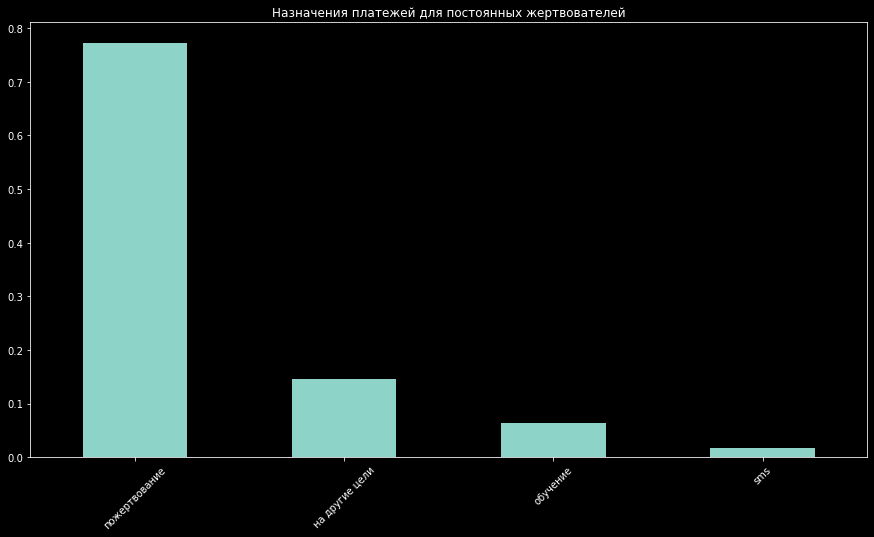

In [44]:
# Назначения платежей
(df['purpose'].value_counts()/len(df['id'])).plot(title='Назначения платежей для постоянных жертвователей',
    kind='bar',
    figsize=(15,8),
    rot=45)
 


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14031 entries, 0 to 14030
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   14031 non-null  object        
 1   date                 14031 non-null  datetime64[ns]
 2   amount               14031 non-null  float64       
 3   is_reccurent         14031 non-null  int64         
 4   purpose              14031 non-null  object        
 5   channel              14031 non-null  object        
 6   gender               14031 non-null  object        
 7   city                 14031 non-null  object        
 8   last_email_activity  11073 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 1.1+ MB


In [46]:
df['date_day'] =df['date'].dt.day
df['date_month'] =df['date'].dt.month
df['date_year'] =df['date'].dt.year
df['last_email_activity_day'] = df['last_email_activity'].dt.day
df['last_email_activity_month'] = df['last_email_activity'].dt.month
df['last_email_activity_year'] = df['last_email_activity'].dt.year

In [47]:
df.head()

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year
0,de5393f9-9585-4057-b7fb-24b69697fc08,2022-07-03 19:49:48,300.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,3,7,2022,3.0,6.0,2022.0
1,81cd4bef-443e-4d36-b34f-664e11182d65,2020-03-14 12:20:02,300.0,0,sms,sms,женский ...,москва,2022-07-18 17:19:02,14,3,2020,18.0,7.0,2022.0
2,d3beb76d-d8b6-47e2-8109-44f1b278943b,2022-04-07 00:00:00,16.0,0,пожертвование,прямые поступления на счет,мужской ...,город неизвестен,NaT,7,4,2022,NaN,NaN,NaN
3,f1310736-b229-4aac-99b7-f13acecf67cb,2019-12-26 02:25:42,300.0,0,на другие цели,sms,no_info,город неизвестен,NaT,26,12,2019,NaN,NaN,NaN
4,61c3d86b-39da-445c-9d7f-9924ce9bda14,2021-06-26 01:26:07,200.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-20 20:32:37,26,6,2021,20.0,7.0,2022.0


In [48]:
#df[df['id']=='29c903a6-ae15-40fc-81fa-4f58d06f3139']

In [49]:
#df[df['id']=='2c65d134-af3b-4a17-afce-72159c28da67']

<AxesSubplot:>

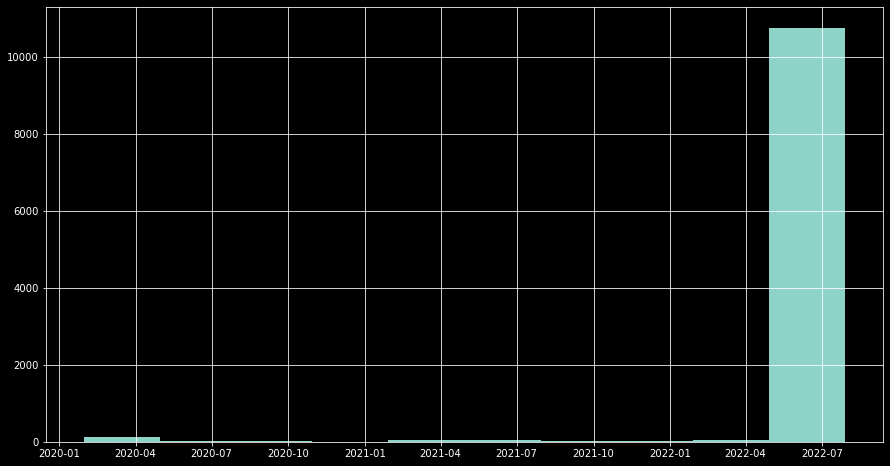

In [50]:
plt.figure(figsize=(15,8))
df['last_email_activity'].hist()

In [51]:
df = df.sort_values(['id', 'date'], ascending=[True, True])
df['life_time'] = df.groupby('id')['date'].apply(lambda x: x.diff().fillna(pd.Timedelta(1, 'D')))#.cumsum())

In [52]:
df['life_time']=df['life_time'].dt.days

In [53]:
df[df['id']=='0f1e1fb0-6467-46c1-8126-4816c5e004f7'].sort_values(['date'], ascending=[True])

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time
12970,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2020-11-25,62.48,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,25,11,2020,NaN,NaN,NaN,1
6800,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2020-12-11,62.50,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,11,12,2020,NaN,NaN,NaN,16
3998,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-01-14,52.26,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,14,1,2021,NaN,NaN,NaN,34
1510,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-06-28,8.65,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,28,6,2021,NaN,NaN,NaN,165
1563,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-06-29,6.68,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,29,6,2021,NaN,NaN,NaN,1
7577,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-07-01,6.64,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,1,7,2021,NaN,NaN,NaN,2
2192,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-07-06,8.92,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,6,7,2021,NaN,NaN,NaN,5
5631,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-07-10,6.92,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,10,7,2021,NaN,NaN,NaN,4
300,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-07-12,5.16,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,12,7,2021,NaN,NaN,NaN,2
12971,0f1e1fb0-6467-46c1-8126-4816c5e004f7,2021-12-12,6.52,0,пожертвование,прямые поступления на счет,мужской ...,другие города россии,NaT,12,12,2021,NaN,NaN,NaN,153


In [54]:
df[df['id']=='de5393f9-9585-4057-b7fb-24b69697fc08'].sort_values(['date'], ascending=True)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time
831,de5393f9-9585-4057-b7fb-24b69697fc08,2020-12-30 11:42:20,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,12,2020,3.0,6.0,2022.0,1
1552,de5393f9-9585-4057-b7fb-24b69697fc08,2020-12-30 11:54:50,300.0,0,на другие цели,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,12,2020,3.0,6.0,2022.0,0
7168,de5393f9-9585-4057-b7fb-24b69697fc08,2021-01-30 11:42:47,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,1,2021,3.0,6.0,2022.0,30
10505,de5393f9-9585-4057-b7fb-24b69697fc08,2021-02-28 11:42:35,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,28,2,2021,3.0,6.0,2022.0,28
3894,de5393f9-9585-4057-b7fb-24b69697fc08,2021-03-30 11:42:31,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,3,2021,3.0,6.0,2022.0,29
13348,de5393f9-9585-4057-b7fb-24b69697fc08,2021-04-30 11:42:41,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,4,2021,3.0,6.0,2022.0,31
6174,de5393f9-9585-4057-b7fb-24b69697fc08,2021-05-30 11:42:37,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,5,2021,3.0,6.0,2022.0,29
2442,de5393f9-9585-4057-b7fb-24b69697fc08,2021-06-30 11:42:51,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,6,2021,3.0,6.0,2022.0,31
13035,de5393f9-9585-4057-b7fb-24b69697fc08,2021-07-30 11:42:33,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,7,2021,3.0,6.0,2022.0,29
4495,de5393f9-9585-4057-b7fb-24b69697fc08,2021-08-30 12:45:51,100.0,1,пожертвование,банковские карты,женский ...,москва,2022-06-03 20:15:57,30,8,2021,3.0,6.0,2022.0,31


In [55]:
df.head(3)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time
9904,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,100.0,0,на другие цели,sms,no_info,город неизвестен,NaT,26,4,2019,NaN,NaN,NaN,1
13529,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-03-27 08:23:58,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,27,3,2020,27.0,7.0,2022.0,1
1628,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-04-29 08:24:29,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,29,4,2020,27.0,7.0,2022.0,33


In [56]:
for column in ['last_email_activity','last_email_activity_day', 'last_email_activity_month', 'last_email_activity_year']:            
    df[column].fillna(0, inplace=True)
df['purpose'].fillna('no_info', inplace=True)


In [57]:
df.isna().mean()

id                           0.0
date                         0.0
amount                       0.0
is_reccurent                 0.0
purpose                      0.0
channel                      0.0
gender                       0.0
city                         0.0
last_email_activity          0.0
date_day                     0.0
date_month                   0.0
date_year                    0.0
last_email_activity_day      0.0
last_email_activity_month    0.0
last_email_activity_year     0.0
life_time                    0.0
dtype: float64

In [58]:
df["amount"].describe().round()

count      14031.0
mean        1722.0
std        29512.0
min            0.0
25%          150.0
50%          350.0
75%          700.0
max      3000000.0
Name: amount, dtype: float64

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14031 entries, 9904 to 12503
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         14031 non-null  object        
 1   date                       14031 non-null  datetime64[ns]
 2   amount                     14031 non-null  float64       
 3   is_reccurent               14031 non-null  int64         
 4   purpose                    14031 non-null  object        
 5   channel                    14031 non-null  object        
 6   gender                     14031 non-null  object        
 7   city                       14031 non-null  object        
 8   last_email_activity        14031 non-null  object        
 9   date_day                   14031 non-null  int64         
 10  date_month                 14031 non-null  int64         
 11  date_year                  14031 non-null  int64         
 12  l

In [60]:
df.sample(2)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time
3865,eba86f53-87f0-45b8-8c08-45e946399ce8,2020-08-26 19:56:03,200.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-18 16:29:31,26,8,2020,18.0,7.0,2022.0,31
6534,c3feba9d-a9b5-4cc2-b97e-040e552c2c66,2021-11-22 14:58:50,100.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-18 16:29:48,22,11,2021,18.0,7.0,2022.0,31


# Исследовательский анализ данных

# amount

In [61]:
df['amount'].describe().T.round(3)

count      14031.000
mean        1722.305
std        29512.340
min            0.010
25%          150.000
50%          350.000
75%          700.000
max      3000000.000
Name: amount, dtype: float64

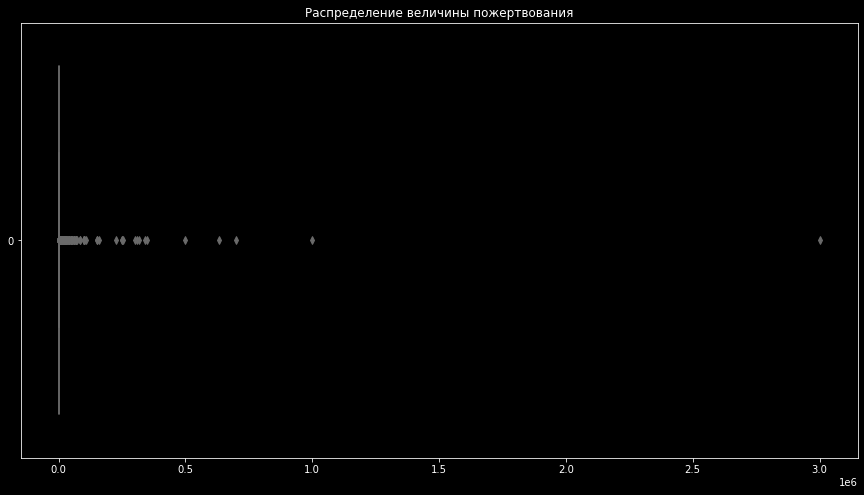

In [62]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df['amount'], orient = 'h')
plt.title('Распределение величины пожертвования')
plt.show()

In [63]:

df_sum_count = df.groupby(['id','is_reccurent'])['amount'].agg(['count','sum', 'mean', 'median']).sort_values(by='sum', ascending=False)
df_sum_count

,,count,sum,mean,median
id,is_reccurent,,,,
29c903a6-ae15-40fc-81fa-4f58d06f3139,0,1,3000000.00,3.000000e+06,3000000.00
99a56103-5bdb-4c2b-af08-0ef1a3d4dc37,0,29,2134289.00,7.359617e+04,200.00
99d83c2d-f72a-4c58-9641-782996644f81,0,1,1000000.00,1.000000e+06,1000000.00
4a6e53ad-4134-499f-8fa5-fbbea120687a,0,8,699800.00,8.747500e+04,6750.00
6ec0197e-4a86-47b6-a3ed-d9b6981bd4fe,0,1,500000.00,5.000000e+05,500000.00
...,...,...,...,...,...
420cc3d4-1252-43ad-9d07-5b8d08f37d01,0,1,0.48,4.800000e-01,0.48
fc1eb8bd-b30f-47a8-b347-0200183861d8,0,1,0.22,2.200000e-01,0.22
b0b6eb05-ac83-4772-a2be-89901bca336f,0,1,0.01,1.000000e-02,0.01


In [64]:
df_sum_count =df_sum_count [['count','sum']]

In [65]:
from sklearn.ensemble import IsolationForest
df_sum_count =df_sum_count [['count','sum']]

isolation_forest = IsolationForest(n_estimators=100) # < напишите код здесь >
sales = df_sum_count['count'].values.reshape(-1, 1) 
isolation_forest.fit(df_sum_count) 
anomaly_scores = isolation_forest.decision_function(df_sum_count)
estimator = isolation_forest.fit_predict(df_sum_count)
outliers = [e for e in estimator if e == -1]
print("Количество аномалий: ", len(outliers))


Количество аномалий:  677


In [66]:

x = df_sum_count.loc[:,['count','sum']].values

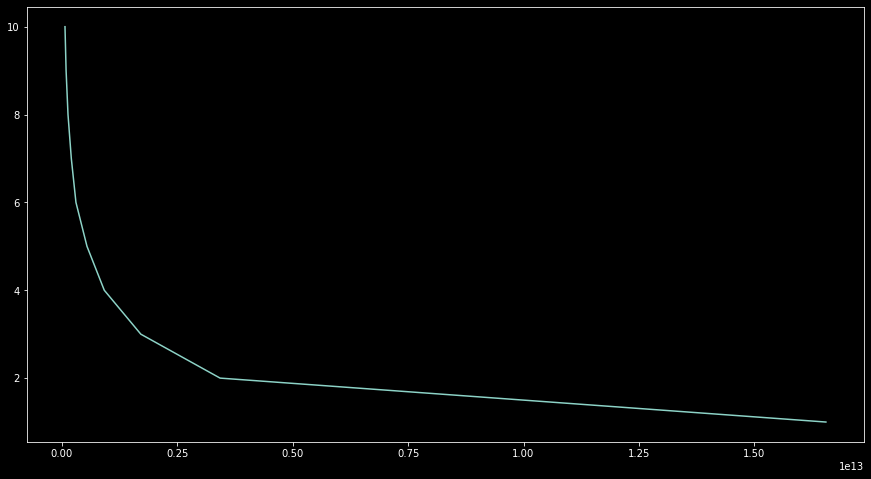

In [67]:
from sklearn.cluster import KMeans
plt.figure(figsize=(15,8))
distortion = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++').fit(x)
    
    distortion.append(kmeans.inertia_)
plt.plot(distortion, range(1,11))

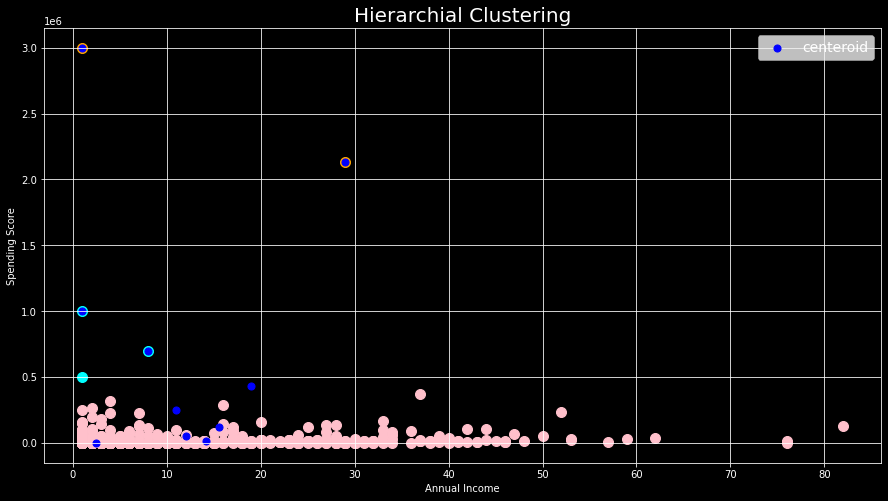

In [68]:
from sklearn.cluster import AgglomerativeClustering

hc_model = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc_model.fit_predict(x)
plt.figure(figsize=(15,8))
plt.scatter(x[y_hc == 0, 0], x[y_hc == 0, 1], s = 100, c = 'pink', label = '')
plt.scatter(x[y_hc == 1, 0], x[y_hc == 1, 1], s = 100, c = 'orange', label = '')
plt.scatter(x[y_hc == 2, 0], x[y_hc == 2, 1], s = 100, c = 'cyan', label = '')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.style.use('fivethirtyeight')
plt.title('Hierarchial Clustering', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show()

In [69]:
df.groupby('id')['amount'].agg(['count','sum', 'mean', 'median']).sort_values(by='count', ascending=False)

,count,sum,mean,median
id,,,,
8a8daecd-40b3-4a41-b53c-06a62be672e6,83,129500.0,1560.240964,1000.0
0b6da68c-558b-4153-806e-b1d775585b88,76,13500.0,177.631579,200.0
f836f738-fb7e-4134-aba8-b6e9ca1e71ea,76,2280.0,30.000000,30.0
85348172-f358-4345-91f1-db8cf0531c8a,73,17202.0,235.643836,100.0
4ecb767f-8830-497b-b395-851d4eacd1f8,65,93500.0,1438.461538,1500.0
...,...,...,...,...
6246ed33-cf41-4f33-88f3-7002a436e483,1,100.0,100.000000,100.0
6254900a-bddc-4b1d-ab9a-9877b9e7bc77,1,500.0,500.000000,500.0
62602f1f-b33b-4a10-a17a-aea4adb4791d,1,300.0,300.000000,300.0


In [70]:
# посмотрим соотношение между городом и общей суммой пожертвований

city_total_sum = df.groupby('city', as_index=False)['amount'].agg(['count','sum', 'mean', 'median'])
city_total_sum = city_total_sum.sort_values(by='sum', ascending=False)
city_total_sum

,count,sum,mean,median
city,,,,
москва,3643,11878614.00,3260.668131,500.0
город неизвестен,7294,9078598.01,1244.666577,300.0
другие города россии,2374,2147334.49,904.521689,300.0
санкт-петербург,494,815789.16,1651.395061,300.0
зарубежные страны,226,245325.00,1085.508850,1000.0


In [71]:
gender_sum = df.groupby('gender')['amount'].agg(['count','sum', 'mean', 'median','std'])
gender_sum

,count,sum,mean,median,std
gender,,,,,
no_info,1569,874724.00,557.504143,200.0,2965.723279
женский,9674,14296757.10,1477.853742,300.0,17513.587634
мужской,2788,8994179.56,3226.032841,500.0,57548.481610


In [72]:
gender_sum = df.groupby(['channel','gender'])['amount'].agg(['count','sum', 'mean', 'median','std'])
gender_sum

count  \
channel                      gender                                                      
sms                          no_info                                              1266   
                             женский                                        ...    190   
                             мужской                                        ...     18   
банковские карты             no_info                                               302   
                             женский                                        ...   8612   
                             мужской                                        ...   2290   
наличные в кассу             женский                                        ...      3   
прямые поступления на счет   no_info                                                 1   
                             женский                                        ...    869   
                             мужской                                        ...    480   

                                                                                        sum  \
channel                      gender                                                           
sms                          no_info                                              350953.00   
                             женский                                        ...    41286.00   
                             мужской                                        ...     5500.00   
банковские карты             no_info                                              523671.00   
                             женский                                        ...  8135989.15   
                             мужской                                        ...  4870450.63   
наличные в кассу             женский                                        ...  1110700.00   
прямые поступления на счет   no_info                                                 100.00   
                             женский                                        ...  5008781.95   
                             мужской                                        ...  4118228.93   

                                                                                          mean  \
channel                      gender                                                              
sms                          no_info                                                277.214060   
                             женский                                        ...     217.294737   
                             мужской                                        ...     305.555556   
банковские карты             no_info                                               1734.009934   
                             женский                                        ...     944.727026   
                             мужской                                        ...    2126.834336   
наличные в кассу             женский                                        ...  370233.333333   
прямые поступления на счет   no_info                                                100.000000   
                             женский                                        ...    5763.845742   
                             мужской                                        ...    8579.643604   

                                                                                   median  \
channel                      gender                                                         
sms                          no_info                                                200.0   
                             женский                                        ...     200.0   
                             мужской                                        ...     300.0   
банковские карты             no_info                                                500.0   
                             женский                                        ...     350.0   
                             му

In [73]:
df.columns

Index(['id', 'date', 'amount', 'is_reccurent', 'purpose', 'channel', 'gender',
       'city', 'last_email_activity', 'date_day', 'date_month', 'date_year',
       'last_email_activity_day', 'last_email_activity_month',
       'last_email_activity_year', 'life_time'],
      dtype='object')

In [74]:
reccurent_total_sum = df.groupby(['is_reccurent','gender'])['amount'].agg(['count','sum', 'mean', 'median','std'])
reccurent_total_sum

count  \
is_reccurent gender                                                      
0            no_info                                              1418   
             женский                                        ...   3443   
             мужской                                        ...   1085   
1            no_info                                               151   
             женский                                        ...   6231   
             мужской                                        ...   1703   

                                                                         sum  \
is_reccurent gender                                                            
0            no_info                                               724724.00   
             женский                                        ...  10508765.10   
             мужской                                        ...   7074375.56   
1            no_info                                               150000.00   
             женский                                        ...   3787992.00   
             мужской                                        ...   1919804.00   

                                                                        mean  \
is_reccurent gender                                                            
0            no_info                                              511.088858   
             женский                                        ...  3052.211763   
             мужской                                        ...  6520.161806   
1            no_info                                              993.377483   
             женский                                        ...   607.926818   
             мужской                                        ...  1127.307105   

                                                                 median  \
is_reccurent gender                                                       
0            no_info                                              200.0   
             женский                                        ...   450.0   
             мужской                                        ...   500.0   
1            no_info                                              300.0   
             женский                                        ...   300.0   
             мужской                                        ...   500.0   

                                                                          std  
is_reccurent gender                                                            
0            no_info                                              3076.383021  
             женский                                        ...  29245.946223  
             мужской                                        ...  92159.802361  
1            no_info                                              1525.228677  
             женский                                        ...   1246.438882  
             мужской                                        ...   1516.054726

In [75]:
id_sum = df.groupby(['id'])['amount'].agg(['count','sum', 'mean', 'median','std'])
id_sum

,count,sum,mean,median,std
id,,,,,
0001afdd-94e3-48f3-b5e7-d5539700425e,1,100.0,100.000000,100.0,NaN
000711b2-2785-461b-bf5b-5cb7d2caba20,21,10500.0,500.000000,500.0,0.000000
0015a100-2d8c-4262-a9b3-bb1461c0c8b8,2,400.0,200.000000,200.0,0.000000
002cb994-10cd-45e9-b6ed-ed7f3c90d7a9,1,1000.0,1000.000000,1000.0,NaN
006f71d7-dfcf-4e7a-b9ad-b4721bef4f7a,1,200.0,200.000000,200.0,NaN
...,...,...,...,...,...
ff946fd1-eef8-4541-a906-bae64527aaa5,1,50.0,50.000000,50.0,NaN
ffa30123-a516-44a7-b030-f83ed369b645,27,4100.0,151.851852,200.0,50.917508
ffb1c4fa-f950-4bb7-a1f2-9dd655298fff,1,100.0,100.000000,100.0,NaN


In [76]:
id_life_time_sum = df.groupby(['id'])['is_reccurent','life_time'].agg(['count','sum'])
id_life_time_sum

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


is_reccurent     life_time     
                                            count sum     count  sum
id                                                                  
0001afdd-94e3-48f3-b5e7-d5539700425e            1   0         1    1
000711b2-2785-461b-bf5b-5cb7d2caba20           21  21        21  814
0015a100-2d8c-4262-a9b3-bb1461c0c8b8            2   0         2    1
002cb994-10cd-45e9-b6ed-ed7f3c90d7a9            1   0         1    1
006f71d7-dfcf-4e7a-b9ad-b4721bef4f7a            1   0         1    1
...                                           ...  ..       ...  ...
ff946fd1-eef8-4541-a906-bae64527aaa5            1   0         1    1
ffa30123-a516-44a7-b030-f83ed369b645           27  26        27  819
ffb1c4fa-f950-4bb7-a1f2-9dd655298fff            1   0         1    1
ffccba23-89ca-4a22-bd8a-7cad2d9eb7f7            3   0         3   22
ffebaa14-fde5-4a6d-9363-fe84a18d68bc            1   0         1    1

[3683 rows x 4 columns]

In [77]:
df_is_reccurent_0 = df.query('life_time ==0 and is_reccurent ==0')
df_is_reccurent_0.groupby(['id'])['life_time'].agg(['count','sum']).sort_values(by='count', ascending=False).head(30)

,count,sum
id,,
6ba628dc-d775-470c-a22d-b0ef55e62628,35,0
85348172-f358-4345-91f1-db8cf0531c8a,16,0
b350a5c5-2001-407c-9c9f-fb98201d5daf,15,0
95969018-2874-42df-883d-c75f45f60581,12,0
eed5ec19-ebdb-425d-a73f-1b65cae71cb8,11,0
b4d2999a-fad5-40b3-b2ff-bcad938df8bb,11,0
c0a41d9a-8628-4443-9419-f27bf6b53de8,11,0
f7f24b47-3341-49eb-90d4-ac2e8f4fb320,6,0
bdaa50f8-8c5b-4d26-880c-54ae83c2fe01,6,0


In [78]:
#df.query('id =="6ba628dc-d775-470c-a22d-b0ef55e62628"')
#df.query('id =="85348172-f358-4345-91f1-db8cf0531c8a"')
#df.query('id =="eed5ec19-ebdb-425d-a73f-1b65cae71cb8"')
#df.query('id =="b4d2999a-fad5-40b3-b2ff-bcad938df8bb"')
#df.query('id =="c0a41d9a-8628-4443-9419-f27bf6b53de8"')
#df.query('id =="f7f24b47-3341-49eb-90d4-ac2e8f4fb320"')
df.query('id =="bdaa50f8-8c5b-4d26-880c-54ae83c2fe01"')

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time
3292,bdaa50f8-8c5b-4d26-880c-54ae83c2fe01,2015-07-20 00:09:10,98.0,0,пожертвование,банковские карты,женский ...,москва,2022-07-19 10:00:01,20,7,2015,19.0,7.0,2022.0,1
6887,bdaa50f8-8c5b-4d26-880c-54ae83c2fe01,2015-07-20 01:14:34,6.0,0,пожертвование,банковские карты,женский ...,москва,2022-07-19 10:00:01,20,7,2015,19.0,7.0,2022.0,0
9585,bdaa50f8-8c5b-4d26-880c-54ae83c2fe01,2015-07-20 01:24:54,102.0,0,пожертвование,банковские карты,женский ...,москва,2022-07-19 10:00:01,20,7,2015,19.0,7.0,2022.0,0
988,bdaa50f8-8c5b-4d26-880c-54ae83c2fe01,2019-05-15 10:28:17,30.0,0,пожертвование,банковские карты,женский ...,москва,2022-07-19 10:00:01,15,5,2019,19.0,7.0,2022.0,1395
7637,bdaa50f8-8c5b-4d26-880c-54ae83c2fe01,2019-05-15 10:30:39,10.0,0,пожертвование,банковские карты,женский ...,москва,2022-07-19 10:00:01,15,5,2019,19.0,7.0,2022.0,0
1416,bdaa50f8-8c5b-4d26-880c-54ae83c2fe01,2020-07-14 18:05:23,20.0,0,пожертвование,банковские карты,женский ...,москва,2022-07-19 10:00:01,14,7,2020,19.0,7.0,2022.0,426
9354,bdaa50f8-8c5b-4d26-880c-54ae83c2fe01,2020-07-23 12:12:59,10.0,0,пожертвование,банковские карты,женский ...,москва,2022-07-19 10:00:01,23,7,2020,19.0,7.0,2022.0,8
4799,bdaa50f8-8c5b-4d26-880c-54ae83c2fe01,2020-12-08 16:39:54,20.0,0,обучение,банковские карты,женский ...,москва,2022-07-19 10:00:01,8,12,2020,19.0,7.0,2022.0,138
7796,bdaa50f8-8c5b-4d26-880c-54ae83c2fe01,2020-12-08 16:43:10,10.0,0,пожертвование,банковские карты,женский ...,москва,2022-07-19 10:00:01,8,12,2020,19.0,7.0,2022.0,0
7489,bdaa50f8-8c5b-4d26-880c-54ae83c2fe01,2020-12-08 16:43:56,10.0,0,обучение,банковские карты,женский ...,москва,2022-07-19 10:00:01,8,12,2020,19.0,7.0,2022.0,0


In [79]:
df.nunique(1)

9904     12
13529    14
1628     16
10917    15
4608     14
         ..
6353     12
4369     12
2698     12
5828     12
12503    16
Length: 14031, dtype: int64

In [80]:
df_500 = df.query('life_time ==1 and amount <500')
df_500

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time
9904,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,100.0,0,на другие цели,sms,no_info,город неизвестен,0,26,4,2019,0.0,0.0,0.0,1
10549,0015a100-2d8c-4262-a9b3-bb1461c0c8b8,2021-07-27 12:15:05,200.0,0,обучение,банковские карты,женский ...,москва,2022-07-18 16:29:48,27,7,2021,18.0,7.0,2022.0,1
7253,006f71d7-dfcf-4e7a-b9ad-b4721bef4f7a,2019-04-27 00:02:19,200.0,0,на другие цели,sms,no_info,город неизвестен,0,27,4,2019,0.0,0.0,0.0,1
5256,008ff16b-30c0-4b44-9141-10f9bab17901,2019-07-24 18:37:59,50.0,0,на другие цели,sms,no_info,город неизвестен,0,24,7,2019,0.0,0.0,0.0,1
12703,009fa801-1558-4699-b0fe-8debbf161195,2017-11-07 10:21:01,100.0,0,на другие цели,sms,no_info,город неизвестен,0,7,11,2017,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10975,ff8daa4d-f7de-490a-aa62-d982fe587e4d,2020-12-01 00:00:00,50.0,0,пожертвование,прямые поступления на счет,женский ...,санкт-петербург,0,1,12,2020,0.0,0.0,0.0,1
1184,ff946fd1-eef8-4541-a906-bae64527aaa5,2019-05-01 20:27:40,50.0,0,на другие цели,sms,no_info,город неизвестен,0,1,5,2019,0.0,0.0,0.0,1
2269,ffa30123-a516-44a7-b030-f83ed369b645,2020-03-27 19:55:41,100.0,1,пожертвование,банковские карты,женский ...,другие города россии,2022-07-18 16:29:47,27,3,2020,18.0,7.0,2022.0,1
6353,ffb1c4fa-f950-4bb7-a1f2-9dd655298fff,2019-04-26 20:37:02,100.0,0,на другие цели,sms,no_info,город неизвестен,0,26,4,2019,0.0,0.0,0.0,1


In [81]:
df_500.groupby(['id'])['life_time'].agg(['count','sum', 'mean', 'median','std'])

,count,sum,mean,median,std
id,,,,,
0001afdd-94e3-48f3-b5e7-d5539700425e,1,1,1.0,1.0,NaN
0015a100-2d8c-4262-a9b3-bb1461c0c8b8,1,1,1.0,1.0,NaN
006f71d7-dfcf-4e7a-b9ad-b4721bef4f7a,1,1,1.0,1.0,NaN
008ff16b-30c0-4b44-9141-10f9bab17901,1,1,1.0,1.0,NaN
009fa801-1558-4699-b0fe-8debbf161195,1,1,1.0,1.0,NaN
...,...,...,...,...,...
ff8daa4d-f7de-490a-aa62-d982fe587e4d,1,1,1.0,1.0,NaN
ff946fd1-eef8-4541-a906-bae64527aaa5,1,1,1.0,1.0,NaN
ffa30123-a516-44a7-b030-f83ed369b645,1,1,1.0,1.0,NaN


In [82]:
life_time_sum = df.groupby(['life_time'])['amount'].agg(['count','sum', 'mean', 'median','std'])
life_time_sum

,count,sum,mean,median,std
life_time,,,,,
0,452,1071952.30,2371.575885,500.000,5678.042069
1,3793,11543833.04,3043.457168,300.000,53240.741511
2,42,324121.01,7717.166905,177.005,47766.895615
3,46,19093.56,415.077391,300.000,488.208939
4,49,21273.92,434.161633,100.000,997.497755
...,...,...,...,...,...
1560,1,1000.00,1000.000000,1000.000,NaN
1596,1,1000.00,1000.000000,1000.000,NaN
1610,1,5000.00,5000.000000,5000.000,NaN


In [83]:
df['date']

9904    2019-04-26 19:19:24
13529   2020-03-27 08:23:58
1628    2020-04-29 08:24:29
10917   2020-05-28 08:24:10
4608    2020-07-27 08:24:02
                ...        
6353    2019-04-26 20:37:02
4369    2021-08-29 00:00:00
2698    2021-09-13 00:00:00
5828    2021-09-19 00:00:00
12503   2017-04-14 21:28:03
Name: date, Length: 14031, dtype: datetime64[ns]

In [84]:
df['date'].sort_index(inplace=True)

In [85]:

df['date'].index.is_monotonic


True

<AxesSubplot:>

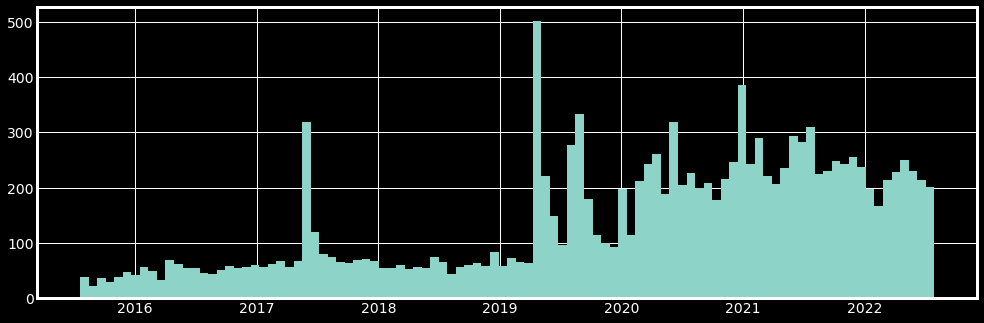

In [86]:
plt.style.use('dark_background')
df['date'].hist(figsize = (15, 5), bins=100)

In [87]:
df_year = df[df['date'].between('2022-01-01 00:00:00', '2022-07-01 00:00:00')]

Boolean Series key will be reindexed to match DataFrame index.


<AxesSubplot:>

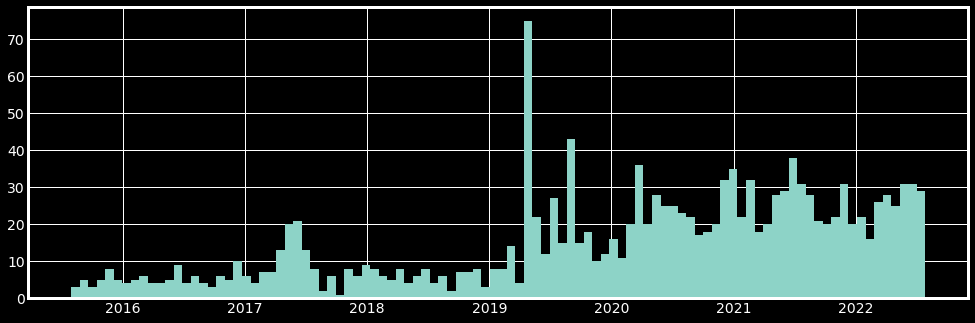

In [88]:
df_year['date'].hist(figsize = (15, 5), bins=100)

In [89]:
df.head()

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time
9904,0001afdd-94e3-48f3-b5e7-d5539700425e,2022-07-03 19:49:48,100.0,0,на другие цели,sms,no_info,город неизвестен,0,26,4,2019,0.0,0.0,0.0,1
13529,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-03-14 12:20:02,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,27,3,2020,27.0,7.0,2022.0,1
1628,000711b2-2785-461b-bf5b-5cb7d2caba20,2022-04-07 00:00:00,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,29,4,2020,27.0,7.0,2022.0,33
10917,000711b2-2785-461b-bf5b-5cb7d2caba20,2019-12-26 02:25:42,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,28,5,2020,27.0,7.0,2022.0,28
4608,000711b2-2785-461b-bf5b-5cb7d2caba20,2021-06-26 01:26:07,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,27,7,2020,27.0,7.0,2022.0,59


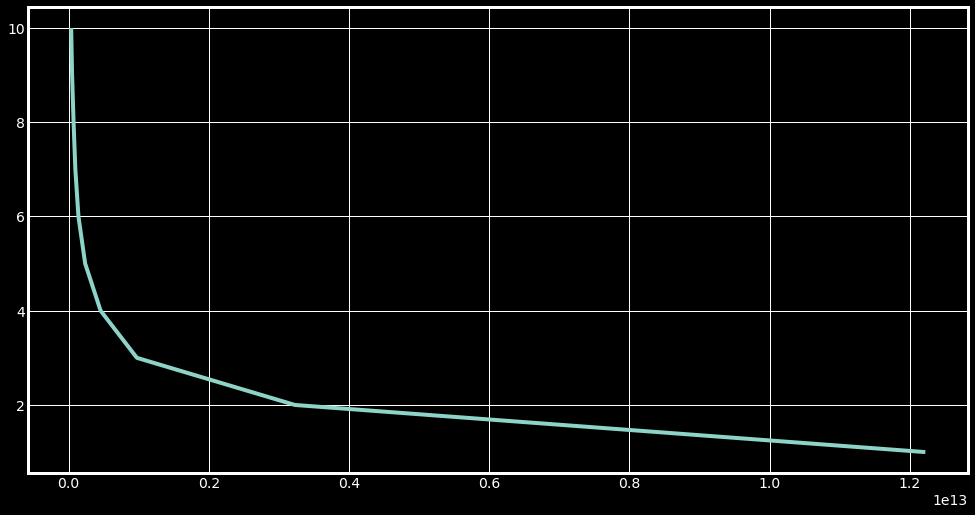

In [90]:
x = df.loc[:,['amount','is_reccurent', 'life_time']].values

from sklearn.cluster import KMeans
plt.figure(figsize=(15,8))
distortion = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++').fit(x)
    
    distortion.append(kmeans.inertia_)
plt.plot(distortion, range(1,11))


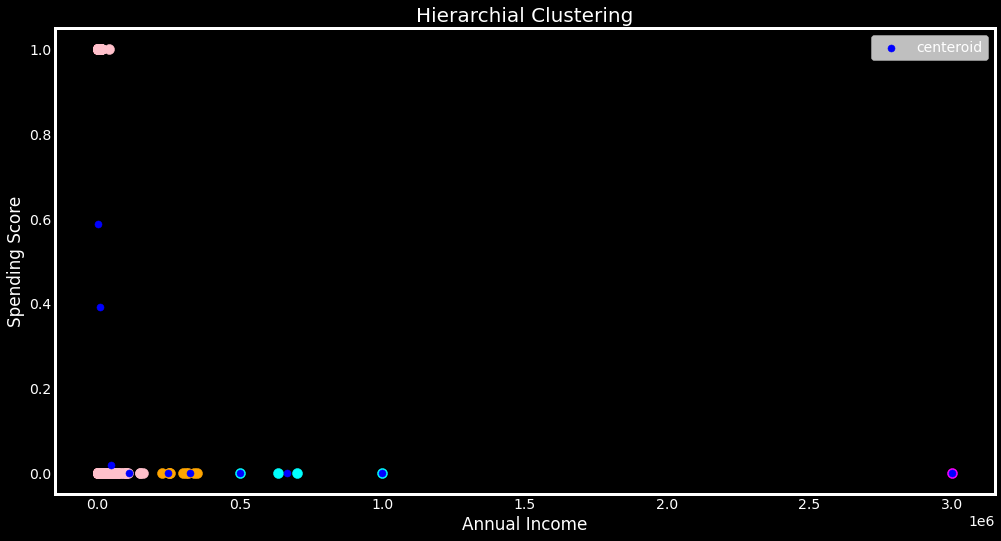

In [91]:
from sklearn.cluster import AgglomerativeClustering

hc_model = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc_model.fit_predict(x)
plt.figure(figsize=(15,8))
plt.scatter(x[y_hc == 0, 0], x[y_hc == 0, 1], s = 100, c = 'pink', label = '')
plt.scatter(x[y_hc == 1, 0], x[y_hc == 1, 1], s = 100, c = 'orange', label = '')
plt.scatter(x[y_hc == 2, 0], x[y_hc == 2, 1], s = 100, c = 'cyan', label = '')
plt.scatter(x[y_hc == 3, 0], x[y_hc == 3, 1], s = 100, c = 'magenta', label = '')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.style.use('fivethirtyeight')
plt.title('Hierarchial Clustering', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show()

In [92]:
#создадим целевой признак
df['churn'] = 1
df.loc[df["is_reccurent"]==1, 'churn'] = 0
# проверим дисбаланс классов

df['churn']= df['churn'].astype('int')
df['churn'].value_counts(normalize=True)

0    0.576224
1    0.423776
Name: churn, dtype: float64

In [93]:
#df = df.query('amount >150 and is_reccurent ==0')

#  Модель CatBoostClassifier

In [94]:

train = df[df['date']<='2022-05-31 00:00:00']
test = df[df['date']>'2022-05-31 00:00:00']

In [95]:
df.columns

Index(['id', 'date', 'amount', 'is_reccurent', 'purpose', 'channel', 'gender',
       'city', 'last_email_activity', 'date_day', 'date_month', 'date_year',
       'last_email_activity_day', 'last_email_activity_month',
       'last_email_activity_year', 'life_time', 'churn'],
      dtype='object')

In [96]:
# удаляем лишние столбцы(информация есть в столбце lifetime) 
df=df.drop(['id', 'date', 'last_email_activity', 'is_reccurent',], axis=1)



In [97]:
# список призноков
X = [ 'purpose', 'channel', 'gender', 'city','amount',
      'date_day', 'date_month', 'date_year', 'last_email_activity_day',
      'last_email_activity_month','last_email_activity_year', 'life_time']
      
# список целевого признака

y=['churn']

#список категориальных признаков
cat_features =['purpose', 'channel', 'gender', 'city']
       

In [98]:
params = {'cat_features': cat_features,
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          'learning_rate': 0.001,
          'random_seed': 42,
          'verbose':50,
          'iterations': 1500}

In [99]:

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

In [100]:
cv_data = cv(
    params = params,
    pool = train_data,
    verbose=False,
    fold_count=5,
    shuffle=False)

Training on fold [0/5]

bestTest = 0.9909219906
bestIteration = 1498

Training on fold [1/5]

bestTest = 0.9891868286
bestIteration = 1495

Training on fold [2/5]

bestTest = 0.9827578332
bestIteration = 1498

Training on fold [3/5]

bestTest = 0.9865953155
bestIteration = 594

Training on fold [4/5]

bestTest = 0.9878611602
bestIteration = 1498



In [101]:
cv_data

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.975403,0.007140,0.691244,0.000042,0.691215,0.000087
1,1,0.978225,0.007857,0.689308,0.000127,0.689241,0.000135
2,2,0.980375,0.009332,0.687487,0.000192,0.687391,0.000154
3,3,0.980162,0.010008,0.685682,0.000390,0.685565,0.000182
4,4,0.980317,0.010170,0.683667,0.000481,0.683530,0.000210
...,...,...,...,...,...,...,...
1495,1495,0.987413,0.003101,0.153789,0.013669,0.146056,0.003552
1496,1496,0.987414,0.003101,0.153767,0.013671,0.146033,0.003550
1497,1497,0.987414,0.003102,0.153743,0.013667,0.146007,0.003558
1498,1498,0.987415,0.003101,0.153713,0.013666,0.145980,0.003554


In [102]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
1498,1498,0.987415,0.003101,0.153713,0.013666,0.14598,0.003554


In [103]:
params = {'cat_features': cat_features,
          'eval_metric': 'AUC',
          #'loss_function': 'Logloss',
          'learning_rate': 0.01,
          'random_seed': 12345,
          'verbose':100,
          'iterations': 1495}



In [104]:
model = CatBoostClassifier(**params)

In [105]:
plt.style.use('dark_background')
model.fit(train_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 8.9ms	remaining: 13.3s
100:	total: 773ms	remaining: 10.7s
200:	total: 1.57s	remaining: 10.1s
300:	total: 2.38s	remaining: 9.42s
400:	total: 3.15s	remaining: 8.61s
500:	total: 3.95s	remaining: 7.83s
600:	total: 4.72s	remaining: 7.03s
700:	total: 5.49s	remaining: 6.21s
800:	total: 6.28s	remaining: 5.44s
900:	total: 7.07s	remaining: 4.66s
1000:	total: 7.89s	remaining: 3.89s
1100:	total: 8.72s	remaining: 3.12s
1200:	total: 9.53s	remaining: 2.33s
1300:	total: 10.3s	remaining: 1.54s
1400:	total: 11.2s	remaining: 749ms
1494:	total: 11.9s	remaining: 0us


In [106]:
roc_auc_cat = roc_auc_score(test[y], model.predict_proba(test[X])[:, 1])
print(f"Accuracy на тестовой выборке : {(model.score(test[X], test[y])):.2f}")
print(f"ROC_AUC для модели CatBoost на тестовой выборке: {roc_auc_cat:.3f}")

Accuracy на тестовой выборке : 0.95
ROC_AUC для модели CatBoost на тестовой выборке: 0.992


In [107]:
#проверим на адекватность модели
#рассчитываем важность признаков с помощью SHAP
model.get_feature_importance(prettified=True)



,Feature Id,Importances
0,life_time,27.977924
1,purpose,20.866562
2,channel,19.892545
3,date_year,7.646659
4,amount,4.584594
5,city,4.213043
6,last_email_activity_month,3.377856
7,date_day,2.761861
8,last_email_activity_day,2.475326
9,last_email_activity_year,2.472856


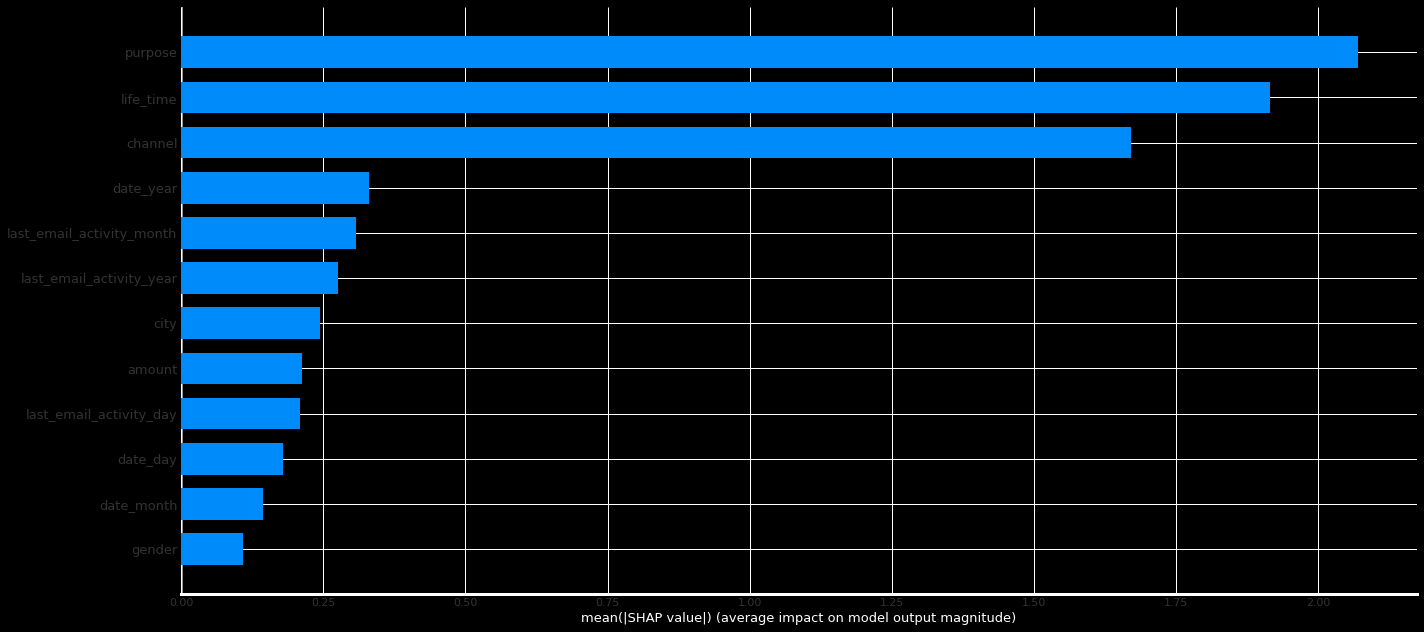

In [108]:
# построим барчарт
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])
shap.summary_plot(shap_values, test[X], plot_type="bar", plot_size=(20,9))

In [109]:
# Рассмотрим SHAP-графики. Построим такой график для каждого наблюдения в датасете

shap.force_plot(explainer.expected_value, shap_values, test[X])

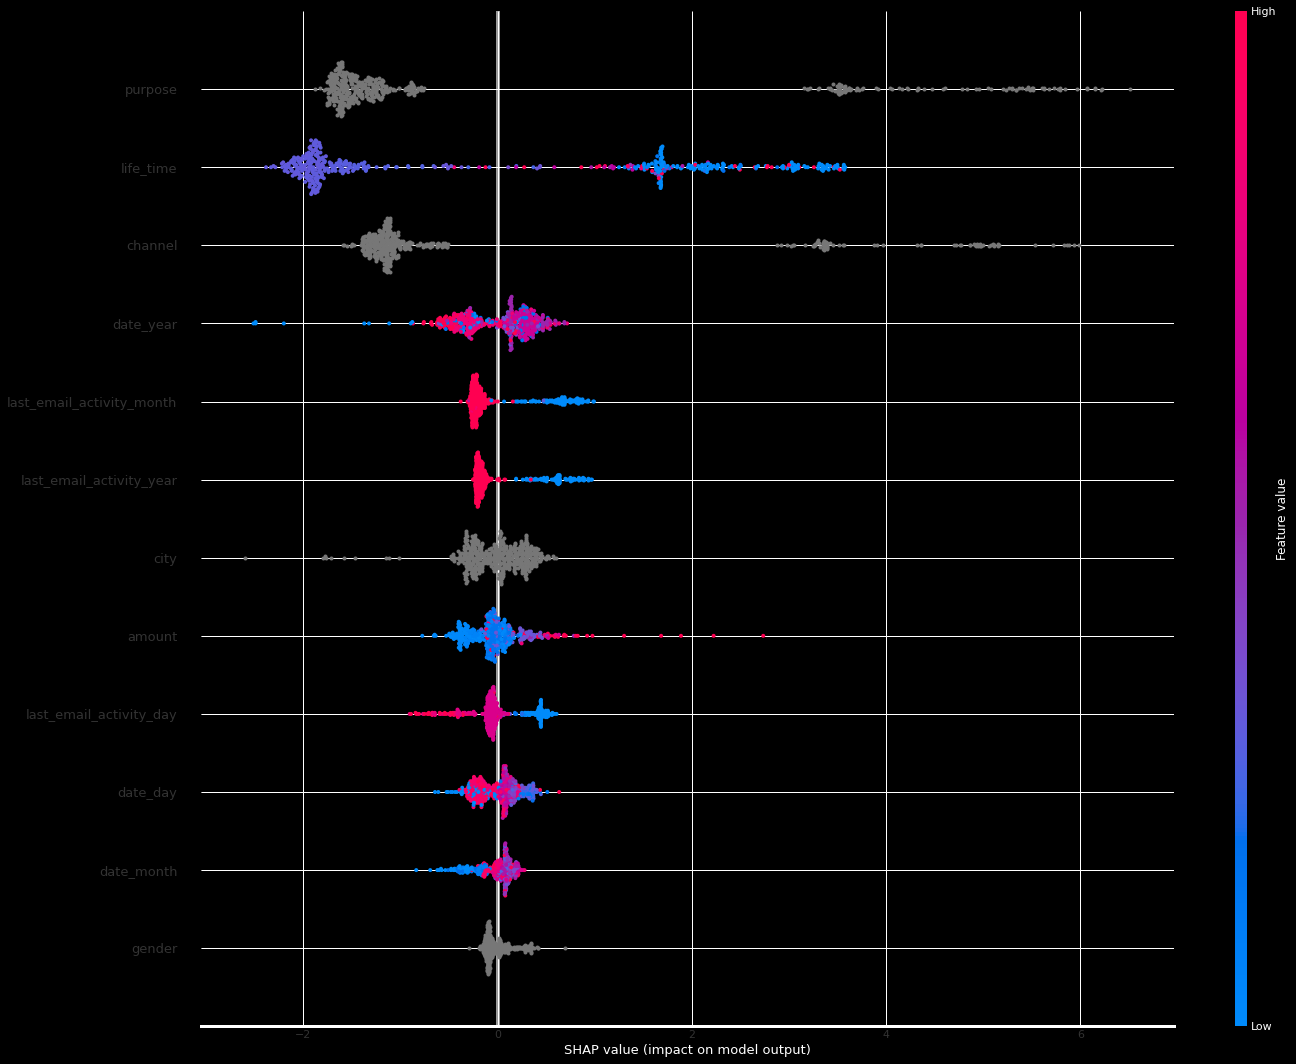

In [110]:
# сортируем объекты по сумме значений SHAP на тестовой выборке 
shap.summary_plot(shap_values, test[X], plot_size=(20,15))

In [111]:
#посмотреть зависимость предсказаний от конкретного признака в виде 2D графика
features = model.get_feature_importance(prettified=True)['Feature Id'].values

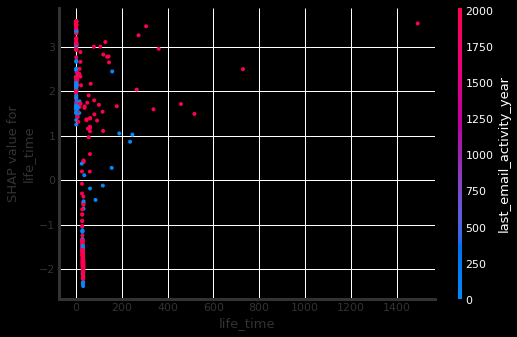

In [112]:
shap.dependence_plot('life_time', shap_values, test[X])

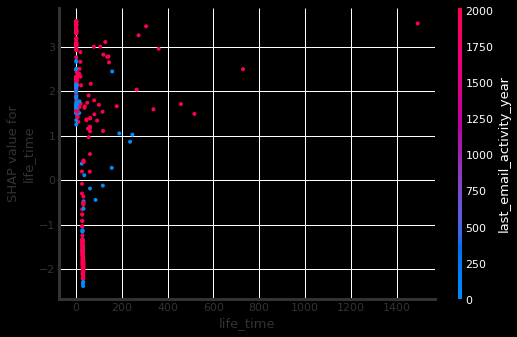

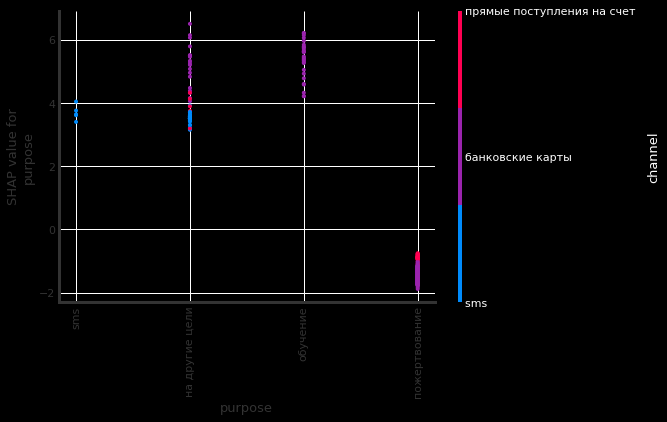

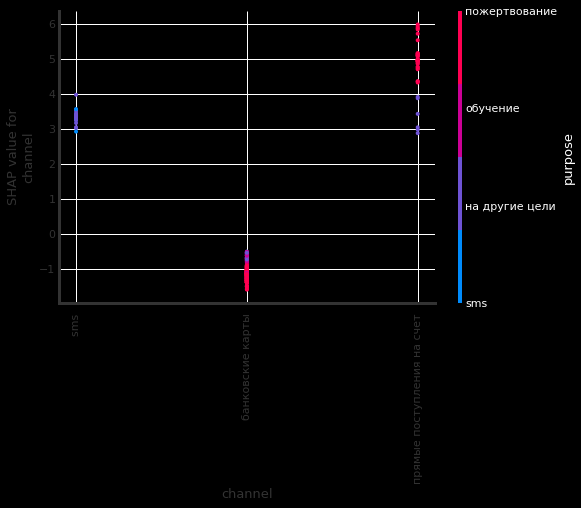

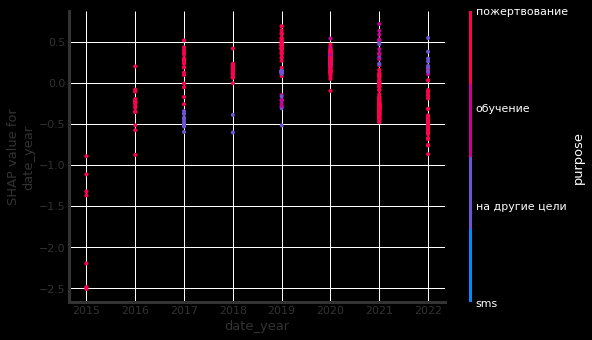

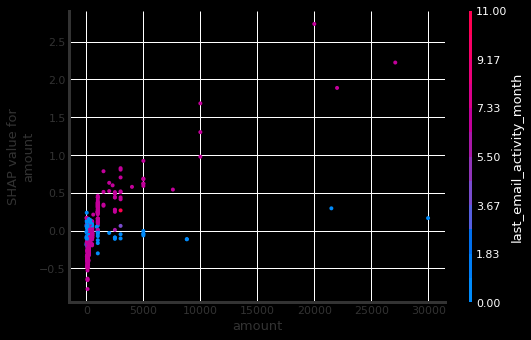

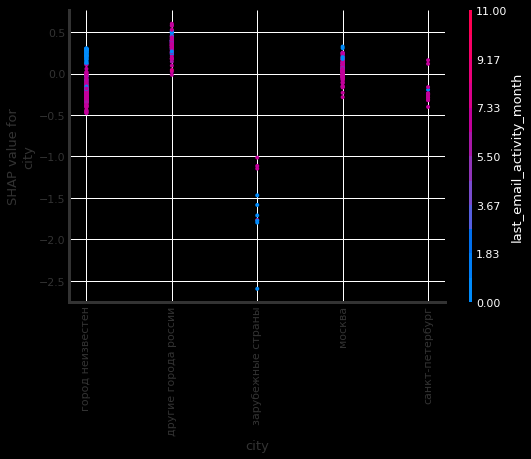

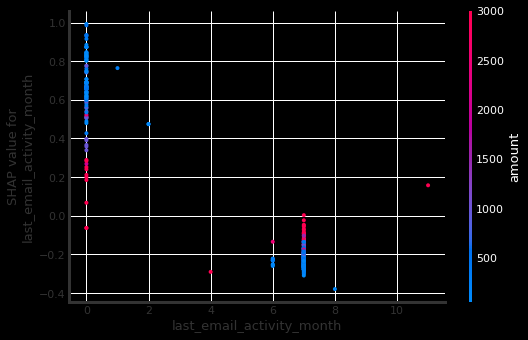

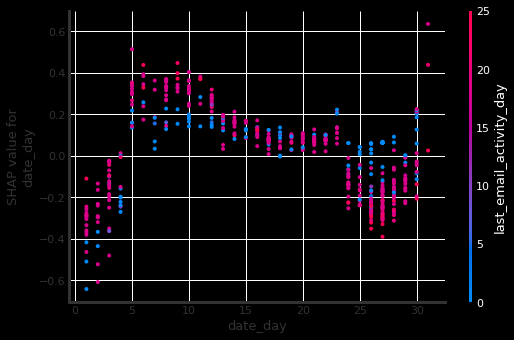

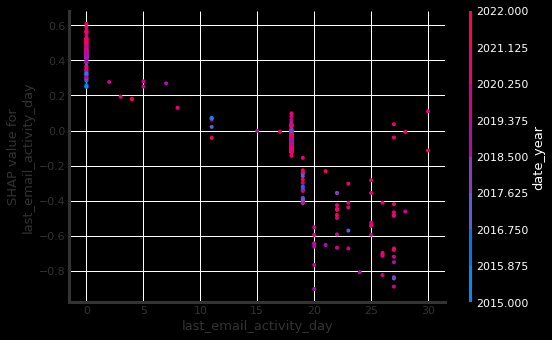

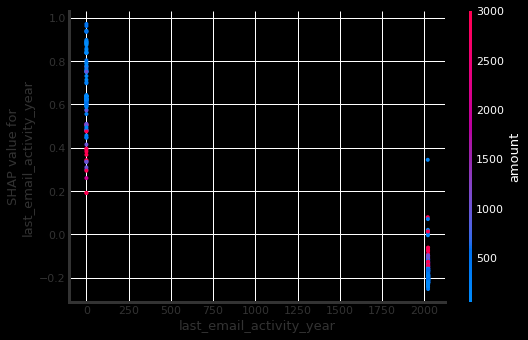

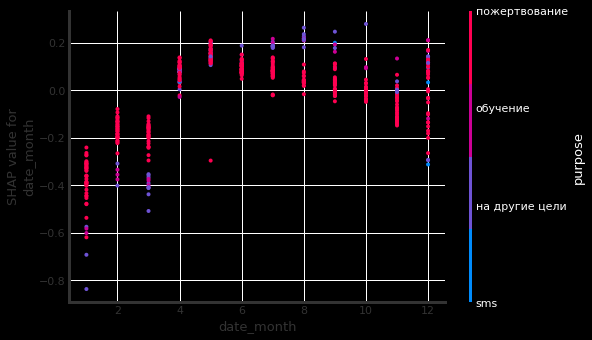

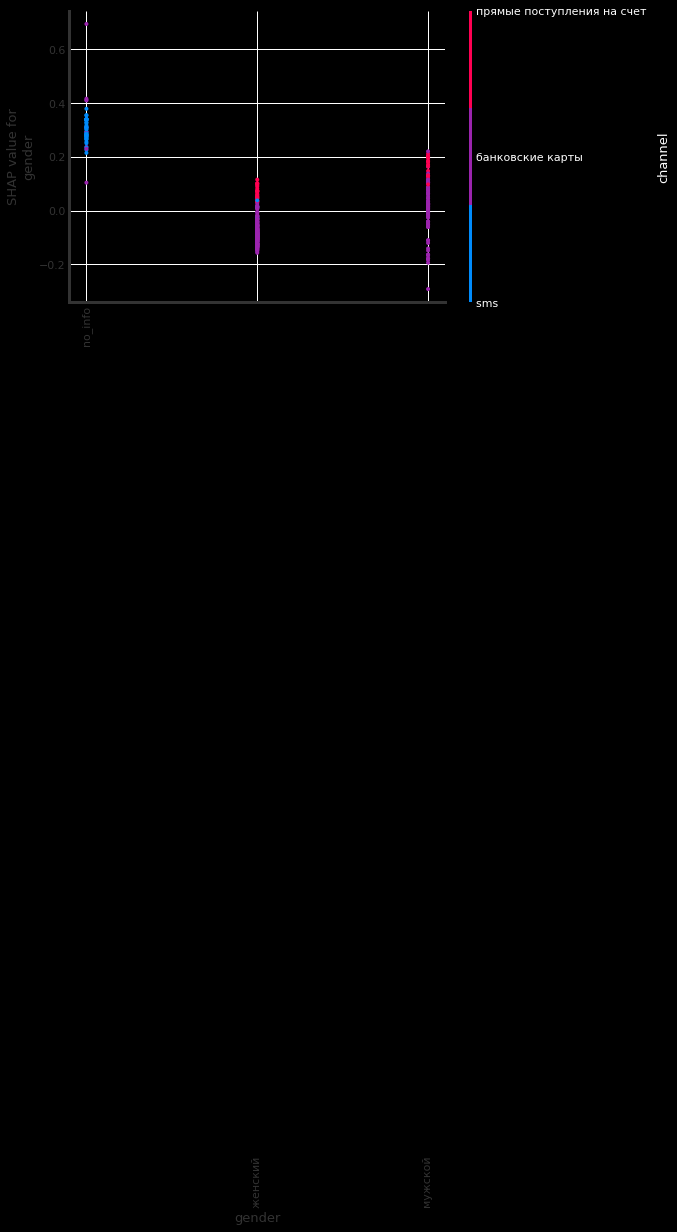

In [113]:
# посмотреть зависимость предсказаний от конкретного признака в виде 2D графика для всех признаков
for features in features:
    shap.dependence_plot(features, shap_values, test[X])

# CatBoostRegressor

In [114]:
lags = []
for lag in tqdm(lags):
    df_year["lag_" + str(lag)] = df_year.groupby("id")["amount"].shift(lag)

0it [00:00, ?it/s]


In [115]:
means = []
for mns in tqdm(means):
    df_year['rolling_median_'+str(mns)] = df_year.groupby(['id'])['amount'].transform(lambda x: x.rolling(mns).median())

0it [00:00, ?it/s]


In [116]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1516 entries, 9025 to 84
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         1516 non-null   object        
 1   date                       1516 non-null   datetime64[ns]
 2   amount                     1516 non-null   float64       
 3   is_reccurent               1516 non-null   int64         
 4   purpose                    1516 non-null   object        
 5   channel                    1516 non-null   object        
 6   gender                     1516 non-null   object        
 7   city                       1516 non-null   object        
 8   last_email_activity        1516 non-null   object        
 9   date_day                   1516 non-null   int64         
 10  date_month                 1516 non-null   int64         
 11  date_year                  1516 non-null   int64         
 12  last_

In [117]:
#df = df.dropna()
df_year.head()

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year,last_email_activity_day,last_email_activity_month,last_email_activity_year,life_time
9025,000711b2-2785-461b-bf5b-5cb7d2caba20,2022-02-18 00:29:02,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,27,1,2022,27.0,7.0,2022.0,30
13476,000711b2-2785-461b-bf5b-5cb7d2caba20,2019-10-27 09:51:01,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,27,2,2022,27.0,7.0,2022.0,30
1834,000711b2-2785-461b-bf5b-5cb7d2caba20,2019-09-10 10:27:08,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,29,5,2022,27.0,7.0,2022.0,91
2609,000711b2-2785-461b-bf5b-5cb7d2caba20,2021-09-27 09:59:55,500.0,1,пожертвование,банковские карты,женский ...,город неизвестен,2022-07-27 10:16:14,27,6,2022,27.0,7.0,2022.0,28
4875,00adba34-1edc-4652-a559-1c0be379a0da,2017-02-28 11:40:00,300.0,0,обучение,банковские карты,женский ...,москва,2022-07-19 00:58:29,13,4,2022,19.0,7.0,2022.0,407


In [118]:
  
train = df_year[df_year['date']<='2022-05-31 00:00:00']
test = df_year[df_year['date']>'2022-05-31 00:00:00']

In [119]:
# удаляем лишние столбцы(информация есть в столбце lifetime) 
df_year=df_year.drop(['id', 'date', 'last_email_activity'], axis=1)


In [120]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())
print(train.shape)
print(test.shape)


2 14021
264 13868
(1451, 16)
(65, 16)


In [121]:
train.shape

(1451, 16)

In [122]:
test.shape

(65, 16)

In [123]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1516 entries, 9025 to 84
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   amount                     1516 non-null   float64
 1   is_reccurent               1516 non-null   int64  
 2   purpose                    1516 non-null   object 
 3   channel                    1516 non-null   object 
 4   gender                     1516 non-null   object 
 5   city                       1516 non-null   object 
 6   date_day                   1516 non-null   int64  
 7   date_month                 1516 non-null   int64  
 8   date_year                  1516 non-null   int64  
 9   last_email_activity_day    1516 non-null   float64
 10  last_email_activity_month  1516 non-null   float64
 11  last_email_activity_year   1516 non-null   float64
 12  life_time                  1516 non-null   int64  
dtypes: float64(4), int64(5), object(4)
memory usage

In [124]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 9025 to 84
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         1451 non-null   object        
 1   date                       1451 non-null   datetime64[ns]
 2   amount                     1451 non-null   float64       
 3   is_reccurent               1451 non-null   int64         
 4   purpose                    1451 non-null   object        
 5   channel                    1451 non-null   object        
 6   gender                     1451 non-null   object        
 7   city                       1451 non-null   object        
 8   last_email_activity        1451 non-null   object        
 9   date_day                   1451 non-null   int64         
 10  date_month                 1451 non-null   int64         
 11  date_year                  1451 non-null   int64         
 12  last_

In [125]:
df.columns

Index(['amount', 'purpose', 'channel', 'gender', 'city', 'date_day',
       'date_month', 'date_year', 'last_email_activity_day',
       'last_email_activity_month', 'last_email_activity_year', 'life_time',
       'churn'],
      dtype='object')

In [126]:
# список призноков
X = ['is_reccurent', 'purpose', 'channel', 'gender', 'city',
       'date_day', 'date_month', 'date_year', 'last_email_activity_day',
       'last_email_activity_month','last_email_activity_year', 'life_time']#'lag_6',
      #'rolling_median_14', 'rolling_median_7',#'lag_14','lag_11','lag_28',
      #, 'lag_42', 'lag_49', 'lag_56',
     #'rolling_median_7',
     #'rolling_median_14',
     #'rolling_median_28']
       
# список целевого признака

y=['amount']

#список категориальных признаков
cat_features =['is_reccurent', 'purpose', 'channel', 'gender', 'city']
       

In [127]:
params={'loss_function':'RMSE',
       'cat_features':cat_features,
       'random_state':42,
       'iterations':2000,
       #'learning_rate': 0.01,
       'depth':  2,
       'verbose':50}



In [128]:


train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

In [129]:
cv_data = cv(
    params = params,
    pool = train_data,
    verbose=100,
    fold_count=5,
    shuffle=False)

Training on fold [0/5]
0:	learn: 10827.2019072	test: 1913.7241380	best: 1913.7241380 (0)	total: 2.83ms	remaining: 5.66s
100:	learn: 10185.4801185	test: 2259.3023674	best: 1806.1372971 (19)	total: 75.3ms	remaining: 1.41s
200:	learn: 9906.6614280	test: 2796.0897421	best: 1806.1372971 (19)	total: 144ms	remaining: 1.29s
300:	learn: 9560.4826949	test: 3362.9578656	best: 1806.1372971 (19)	total: 203ms	remaining: 1.15s
400:	learn: 9135.6607678	test: 4015.4973026	best: 1806.1372971 (19)	total: 247ms	remaining: 985ms
500:	learn: 8697.6392217	test: 5230.1572234	best: 1806.1372971 (19)	total: 292ms	remaining: 872ms
600:	learn: 8417.7851458	test: 6465.4513107	best: 1806.1372971 (19)	total: 343ms	remaining: 798ms
700:	learn: 8222.3926870	test: 7342.6612663	best: 1806.1372971 (19)	total: 416ms	remaining: 771ms
800:	learn: 8128.4392506	test: 7892.1192344	best: 1806.1372971 (19)	total: 565ms	remaining: 845ms
900:	learn: 8051.8563740	test: 8008.5791167	best: 1806.1372971 (19)	total: 625ms	remaining: 76

1999:	learn: 6961.4178496	test: 7720.8517866	best: 7041.7696054 (61)	total: 1.16s	remaining: 0us

bestTest = 7041.769605
bestIteration = 61

Training on fold [4/5]
0:	learn: 8299.6656817	test: 14036.7272203	best: 14036.7272203 (0)	total: 1.27ms	remaining: 2.54s
100:	learn: 7854.9719012	test: 14025.2846164	best: 13963.6513193 (35)	total: 43.5ms	remaining: 817ms
200:	learn: 7731.3602696	test: 14091.8228966	best: 13963.6513193 (35)	total: 88.8ms	remaining: 795ms
300:	learn: 7704.8132533	test: 14105.0709975	best: 13963.6513193 (35)	total: 132ms	remaining: 746ms
400:	learn: 7699.8539742	test: 14108.6739667	best: 13963.6513193 (35)	total: 175ms	remaining: 698ms
500:	learn: 7693.4168489	test: 14105.7164953	best: 13963.6513193 (35)	total: 242ms	remaining: 723ms
600:	learn: 7674.9855533	test: 14100.0857302	best: 13963.6513193 (35)	total: 291ms	remaining: 677ms
700:	learn: 7627.4456191	test: 14120.6498041	best: 13963.6513193 (35)	total: 340ms	remaining: 630ms
800:	learn: 7590.9178470	test: 14136

In [130]:
cv_data

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,7852.611902,6412.476813,9635.497006,1404.440653
1,1,7841.810986,6420.146160,9626.995674,1402.644312
2,2,7832.935392,6425.834904,9617.571710,1399.641234
3,3,7824.382021,6430.830669,9610.988016,1398.077501
4,4,7814.869918,6437.649493,9599.652015,1400.793656
...,...,...,...,...,...
1995,1995,10428.606899,6223.188937,6469.190369,1516.439264
1996,1996,10428.372601,6223.701946,6468.977047,1516.336716
1997,1997,10428.032881,6224.213153,6468.683660,1516.427631
1998,1998,10427.745538,6224.686743,6468.332799,1516.272672


In [131]:
cv_data[cv_data['test-RMSE-mean'] == cv_data['test-RMSE-mean'].max()]

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
1993,1993,10428.666579,6223.108669,6470.522846,1516.510878


In [132]:
params={'loss_function':'RMSE',
        'cat_features':cat_features,
        'random_state':42,
        'iterations':1993, 
        #'learning_rate': 0.01,
        'depth':  3,
        'verbose':100}



In [133]:
model = CatBoostRegressor(**params)

In [134]:
model.fit(train[X], train[y], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.024726
0:	learn: 9631.0976904	total: 2.79ms	remaining: 5.59s
100:	learn: 9153.0286874	total: 81.9ms	remaining: 1.54s
200:	learn: 8749.4885551	total: 151ms	remaining: 1.35s
300:	learn: 8432.6126595	total: 221ms	remaining: 1.25s
400:	learn: 7872.0621676	total: 288ms	remaining: 1.15s
500:	learn: 7646.1071942	total: 350ms	remaining: 1.04s
600:	learn: 7440.6113346	total: 410ms	remaining: 954ms
700:	learn: 7309.5834667	total: 474ms	remaining: 878ms
800:	learn: 7240.1209099	total: 537ms	remaining: 803ms
900:	learn: 7180.9734036	total: 598ms	remaining: 729ms
1000:	learn: 7043.8473447	total: 664ms	remaining: 662ms
1100:	learn: 6719.0696725	total: 730ms	remaining: 595ms
1200:	learn: 6531.7134666	total: 797ms	remaining: 530ms
1300:	learn: 6355.2428684	total: 853ms	remaining: 458ms
1400:	learn: 6244.0621026	total: 913ms	remaining: 390ms
1500:	learn: 6089.2562829	total: 1s	remaining: 333ms
1600:	learn: 5949.1937720	total: 1.08s	remaining: 269ms
1700:	learn: 5820.6294157	total

In [135]:
predicted_cat_train = model.predict(train[X])

In [136]:

predicted_cat_test = model.predict(test[X])

In [137]:

rmse_cat_train = mean_squared_error(train[y], predicted_cat_train)** 0.5
rmse_cat_train

7549.6274934052635

In [138]:
rmse_cat_test = mean_squared_error(test[y], predicted_cat_test)** 0.5
rmse_cat_test

1348.3637380850457

In [139]:
mae_cat_train = mean_absolute_error(train[y], predicted_cat_train)
mae_cat_train

1756.6918506636598

In [141]:
mae_cat_test = mean_absolute_error(test[y], predicted_cat_test)
                                   
mae_cat_test

936.9603496561601

In [142]:
mean_absolute_percentage_error(train[y], predicted_cat_train)

21.900633243521305

In [143]:

mean_absolute_percentage_error(test[y], predicted_cat_test)

84.32143740780806

In [144]:
#проверим на адекватность модели
#рассчитываем важность признаков с помощью SHAP
model.get_feature_importance(prettified=True)



,Feature Id,Importances
0,life_time,36.025393
1,city,26.756868
2,is_reccurent,16.942876
3,date_month,7.219284
4,date_day,4.499096
5,channel,3.167391
6,purpose,1.934243
7,last_email_activity_month,1.342297
8,last_email_activity_day,0.974120
9,last_email_activity_year,0.753275


In [145]:

shap.initjs()

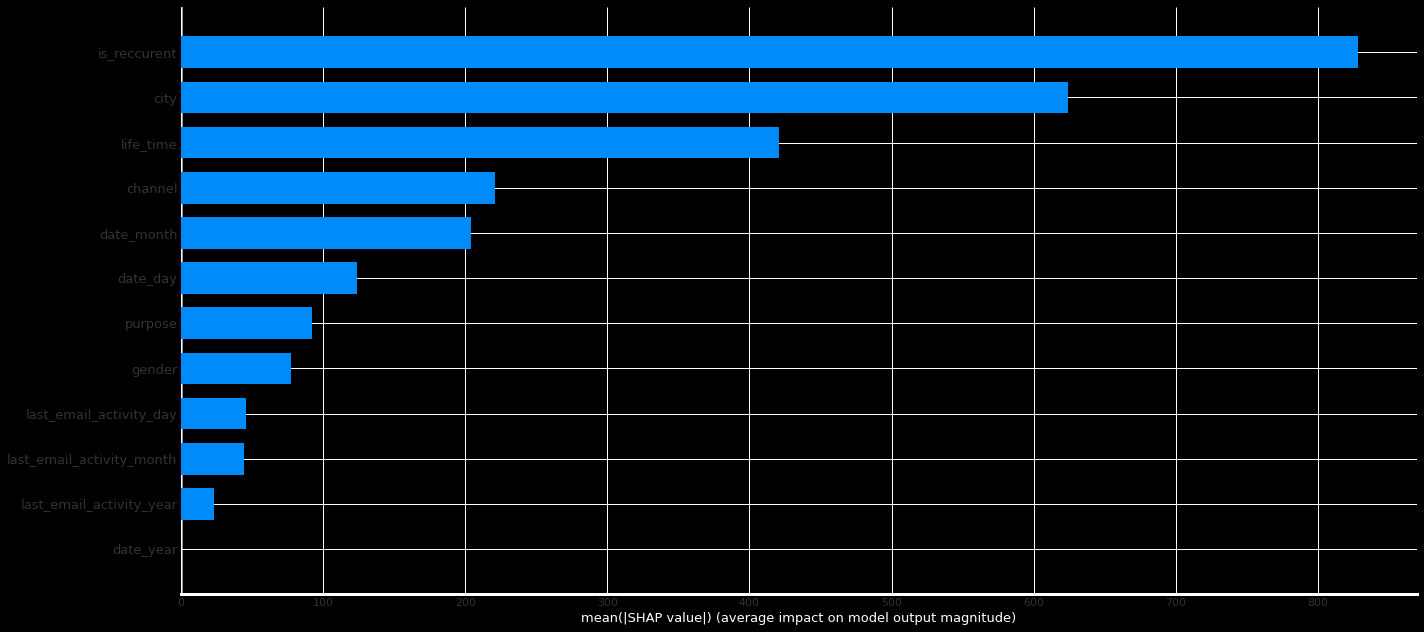

In [146]:
# построим барчарт
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])
shap.summary_plot(shap_values, test[X], plot_type="bar", plot_size=(20,9))

In [147]:
# Рассмотрим SHAP-графики. Построим такой график для каждого наблюдения в датасете

shap.force_plot(explainer.expected_value, shap_values, test[X])

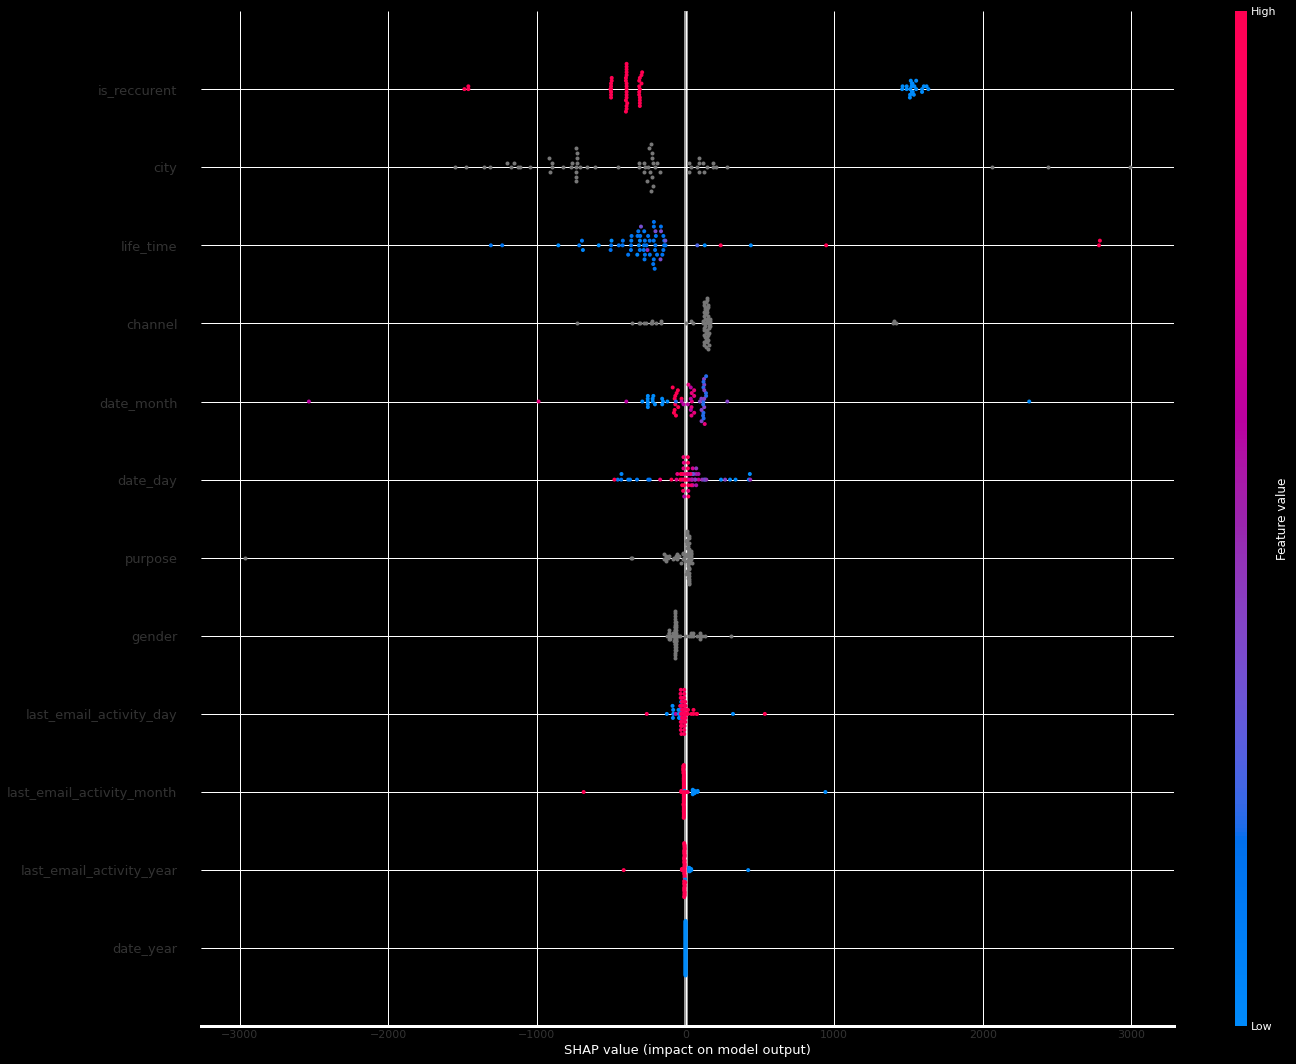

In [148]:
# сортируем объекты по сумме значений SHAP на тестовой выборке 
shap.summary_plot(shap_values, test[X], plot_size=(20,15))

In [149]:
#посмотреть зависимость предсказаний от конкретного признака в виде 2D графика
features = model.get_feature_importance(prettified=True)['Feature Id'].values

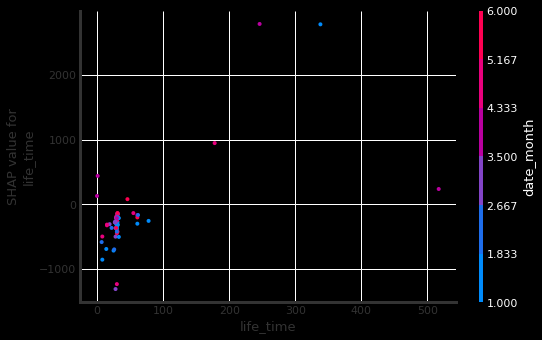

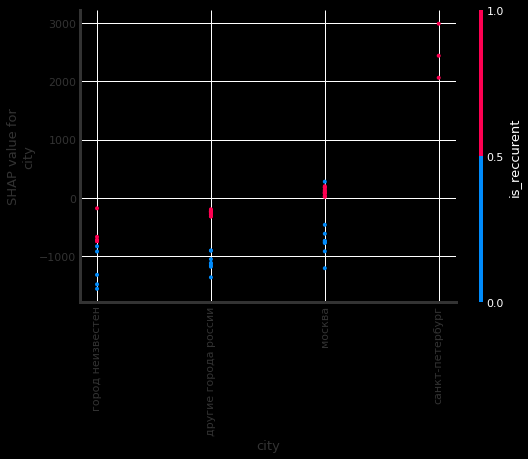

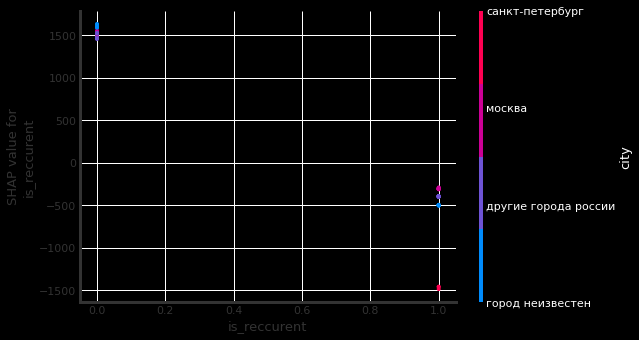

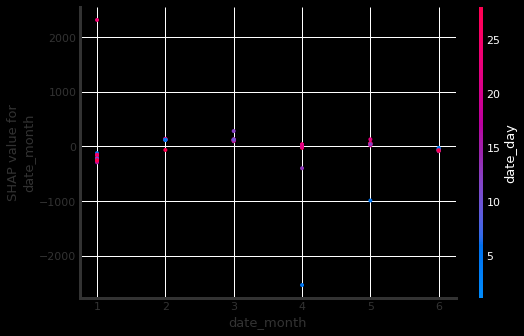

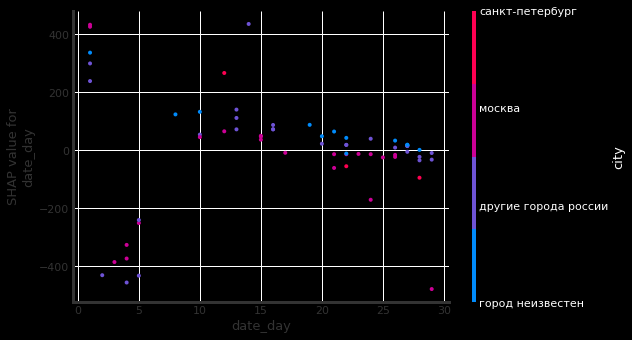

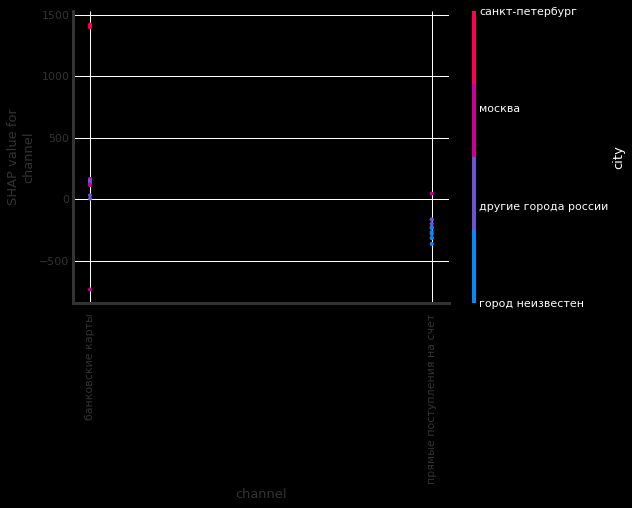

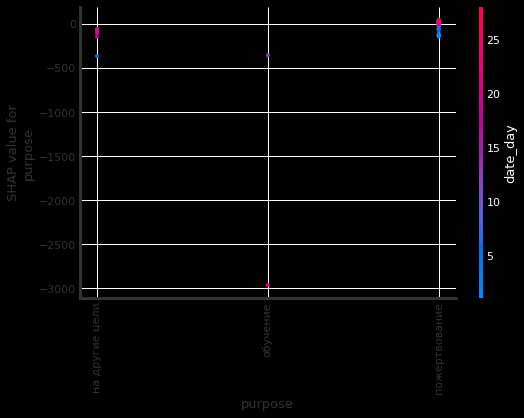

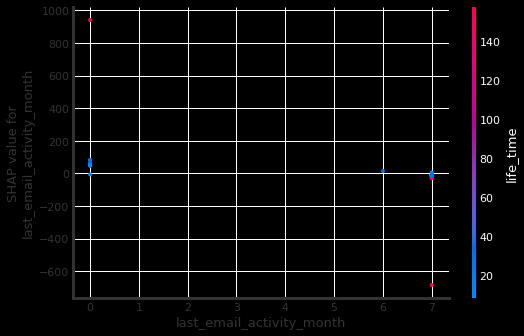

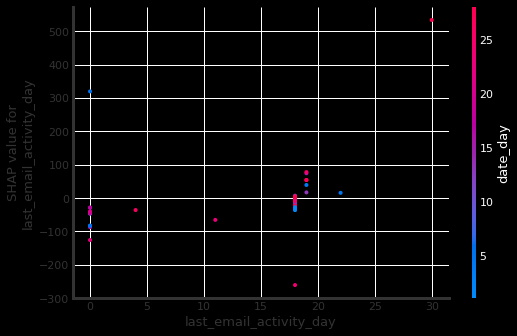

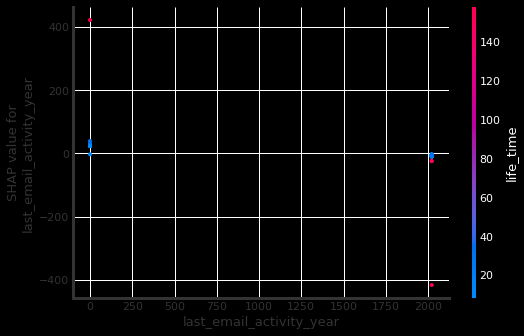

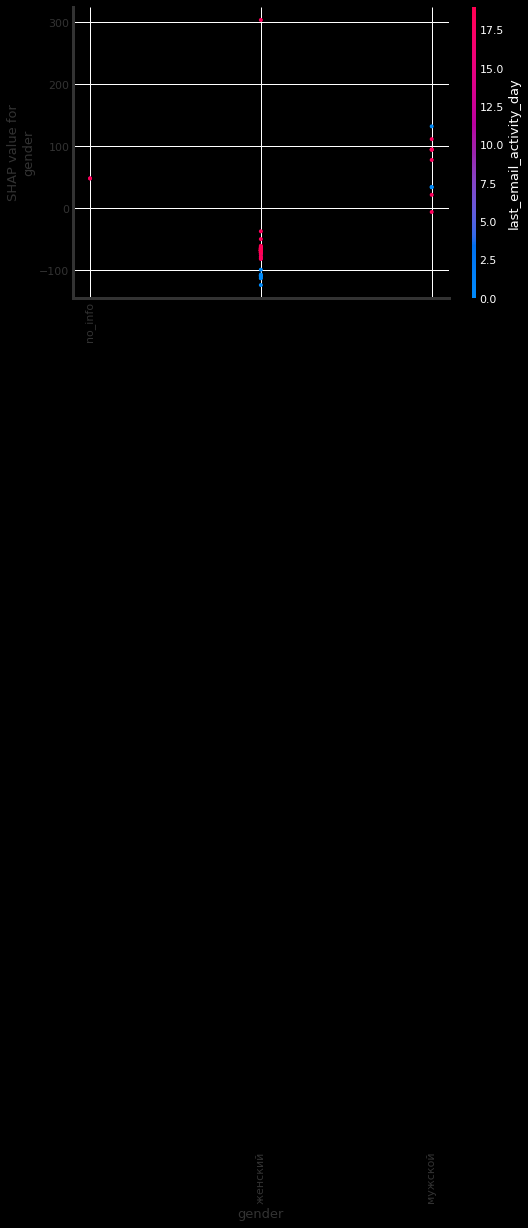

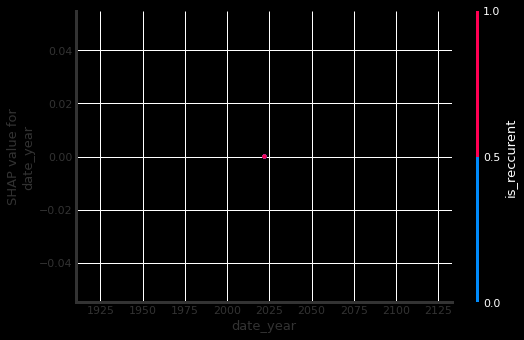

In [150]:
# посмотреть зависимость предсказаний от конкретного признака в виде 2D графика для всех признаков
for features in features:
    shap.dependence_plot(features, shap_values, test[X])
    

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14031 entries, 9904 to 12503
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   amount                     14031 non-null  float64
 1   purpose                    14031 non-null  object 
 2   channel                    14031 non-null  object 
 3   gender                     14031 non-null  object 
 4   city                       14031 non-null  object 
 5   date_day                   14031 non-null  int64  
 6   date_month                 14031 non-null  int64  
 7   date_year                  14031 non-null  int64  
 8   last_email_activity_day    14031 non-null  float64
 9   last_email_activity_month  14031 non-null  float64
 10  last_email_activity_year   14031 non-null  float64
 11  life_time                  14031 non-null  int64  
 12  churn                      14031 non-null  int64  
dtypes: float64(4), int64(5), object(4)
memory u

In [ ]:
train[y].mean(), test[y].mean()